In [1]:
# DEFINE HERE THE VARIABLES OF THIS NOTEBOOK:
# NOTE THAT WE WILL ALSO DEFINE SOME OTHER VARIABLES BELOW, INFERRED FROM THE PREVIOUS CELLS
# RUN THIS NOTEBOOK CELL BY CELL
testsetname = 'allset_test.hdf'
hyperparams = {
    'n_estimators': [50, 100, 200],
    'max_samples': [512, 1024, 2048, 4096, 8192, 16384],
    'random_state': [11, 25, 42]
}
num_features = 31

MAXROWS = 25
SCORES = ['roc_auc_score', 'average_precision_score', 'log_loss']
SCORE = 'roc_auc_score'

SRCDIR = '../evaluations/results/'  # relative to the current working directory, which MUST be sod/jupyter

print('Global variables defined')

Global variables defined


In [2]:
# DEFINE CODE RELATED STUFF, IMPORTS, AND CUSTOM FUNCTIONS:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load
from collections import defaultdict
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# import sod.core.dataset as scd
# importlib.reload(scd)
# import sod.core.evaluation as sce
# importlib.reload(sce)
from itertools import permutations
import re
import matplotlib
import numpy as np
from sklearn.metrics import roc_curve
from sod.core.metrics import confusion_matrix as sod_cm


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# other stuff:

import pandas as pd
# for printing, we can do this:
# with pd.option_context('display.max_rows', -1, 'display.max_columns', 5):
# or we simply set once here the max_col_width
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', 500)


from IPython.display import HTML, display_html # https://stackoverflow.com/a/36313217
def printhtml(what):
    display_html(what, raw=True)


# display(DataFrame) nicely displays a DataFrame. Override it to re-arrange the columns of the passed
# dataframe is an evaluation dataframe:
from IPython.display import display as o_display
def display(*a, **kw):
    if len(a) == 1 and not kw and isinstance(a[0], pd.DataFrame):
        _firstcols = ['feats'] + list(hyperparams.keys()) + SCORES
        if all(_ in a[0].columns for _ in _firstcols):
            _lastcols = ['behaviour', 'contamination', 'tr_set', '_key']
            if all(_ in a[0].columns for _ in _lastcols):
                cols = _firstcols + [_ for _ in a[0].columns if _ not in _firstcols and _ not in _lastcols] + _lastcols
                a = list(a)
                a[0] = a[0][cols]
    o_display(*a, **kw)

    
# base colors are alternate after inspecting them in a grayscale screen
# to make them recognizable also in black and white printouts:
basecolors = [
    'tab:red',
    'tab:olive',
    'tab:blue',
    'tab:cyan',
    'tab:brown',
    'tab:green',
    'tab:orange',
    'tab:pink',
    'tab:purple',
    'tab:gray',
]


def plot_scores(sem_df):
    axs = {}
    feat_labels = [_.replace('psd@', '').replace('sec', '').replace(',', ' ') for _ in feats]
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(1, len(SCORES))
                          #height_ratios=heights,
                          #width_ratios=[1, 1, 1])

    for j, score_name in enumerate(SCORES):
        ax = fig.add_subplot(gs[0, j])
        minx, maxx = None, None
        axs[score_name] = ax
        for i, f in enumerate(feats):
            df_ = sem_df[sem_df.feats == f]
            min_, median, max_ =  df_[score_name].min(), df_[score_name].median(), df_[score_name].max()

            xerr = [[median-min_], [max_-median]]
            color = basecolors[len(f.split(','))-1]

            # print errbar background:
            ax.barh(i, left=min_, width=max_-min_, height=0.75, alpha=0.1, color=color, linewidth=0)
            # print errbar border:
            #ax.barh(i, left=min_, width=max_-min_, height=0.75, alpha=1, fill=False, ec=color, linewidth=1)

            ax.errorbar(median, i, xerr=xerr, color=color,
                        marker='|', capsize=0,
                        linewidth=0, elinewidth=0, capthick=0, markersize=20, mew=2)

            # don't know why axes does not set automatically xlim, maybe barh is not working as expected?
            if i == 0:
                minx, maxx = min_, max_
            else:
                minx, maxx = min(minx, min_), max(maxx, max_)
                    

        margin = (maxx - minx) * 0.05
        ax.set_xlim(minx-margin/2, maxx+margin/2)
        
        ax.set_yticks(list(range(len(feats))))
        if j == 0:
            ax.set_ylabel('Features (PSD periods)')
            ax.set_yticklabels(feat_labels)
        else:
            ax.set_yticklabels([])

        ax.set_xlabel(score_name.replace('_', ' '))
        ax.grid()
    return axs


def samex(axes):
    _min, _max = 0, 1
    for i, ax in enumerate(axes):
        cmin, cmax = ax.get_xlim()
        if i == 0 or cmin < _min:
            _min = cmin
        if i == 0 or cmax > _max:
            _max = cmax
    for i, ax in enumerate(axes):
        ax.set_xlim(_min, _max)
    return _min, _max


def samey(axes):
    _min, _max = 0, 1
    for i, ax in enumerate(axes):
        cmin, cmax = ax.get_ylim()
        if i == 0 or cmin < _min:
            _min = cmin
        if i == 0 or cmax > _max:
            _max = cmax
    for i, ax in enumerate(axes):
        ax.set_ylim(_min, _max)
    return _min, _max


print('Code functions defined and libraries imported')

Code functions defined and libraries imported


In [3]:
maindir = os.path.abspath(os.path.join(os.getcwd(), SRCDIR))
assert os.path.isdir(maindir)


print('Loading summary evaluation metrics')
# load summary evaluation metrics, and filter with only those used for testing:
sem_df = pd.read_hdf(os.path.join(maindir, 'summary_evaluationmetrics.hdf'))
#Take only evaluations of chosen testsetname (see cell above)
sem_df = sem_df[sem_df._key.str.match('^.+/%s$' % testsetname.replace('.', '\\.'))].copy()
# re-arrange columns order:
_firstcols = ['feats'] + list(hyperparams.keys()) + SCORES
sem_df = sem_df[_firstcols + [_ for _ in sem_df.columns if _ not in _firstcols]]
sem_df = sem_df.sort_values([SCORE], ascending=False)
# print stuff:
assert len(sem_df) == num_features * np.product([len(_) for _ in hyperparams.values()])
printhtml('<h3>Found %d evaluation metrics of %d models computed on test set <i>%s</i> and sorted by "%s". Showing first %d:</h3>' %
      (len(sem_df), len(sem_df), testsetname, SCORE, MAXROWS))
display(sem_df.head(MAXROWS))


groupcolumns = ['feats' ] + list(_ for _ in hyperparams.keys() if _ != 'random_state')
print()
print('Grouping rows by same "random_state" to better visualzie the Evaluation dataframe')
print('Column "%s" will show the median value, columns "%s_min" "%s_max" will be added):' % (SCORE, SCORE, SCORE))
sem_df2 = []
for i, (keys, df_) in enumerate(sem_df.groupby(groupcolumns, sort=False)):
    df_ = df_.copy()
    df_['_tmp_sort_key'] = df_[SCORE].median()
    # first round to decimals:
    for s in list(SCORES) + ['best_th_pr_curve', 'best_th_roc_curve']:
        df_[s] = df_[s].round(4)
    # then group all scores into a list: all rows will have the same values of [SCORES] + ['random_state']:
    for s in list(SCORES) + ['random_state'] + ['best_th_pr_curve', 'best_th_roc_curve']:
        df_[s] = str(df_[s].tolist())
    # and now take just the first row:
    sem_df2.append(df_[0:1])
sem_df2 = pd.concat(sem_df2, sort=False, ignore_index=True, axis=0, copy=True)
sem_df2 = sem_df2.sort_values(['_tmp_sort_key'], ascending=False).drop('_tmp_sort_key', 1)
display(sem_df2.head(MAXROWS))


feats = pd.unique(sem_df.feats)
def sortfunc(feats):
    psds = []
    for f in feats.split(','):
        psds.append(float(f.replace('psd@', '').replace('sec', '')))
    return np.sum([(10 ** i) * p for i,p in enumerate(psds)])
feats = sorted(feats, key=sortfunc)
assert len(feats) == num_features
for f in feats:
    # for each feature, the number of models/evaluations is the product of all hyperparams:
    assert len(sem_df[sem_df.feats == f]) == np.product([len(_) for _ in hyperparams.values()])  #3 * 4 * 2
print()
printhtml('<b>Evaluation dataframe has %d unique features:</b>' % len(feats))
printhtml("<div style='border:1px solid #ddd;max-height:5em;overflow:auto'>" + "<br>".join(feats) + "</div>")


print()
print('DONE')

Loading summary evaluation metrics


Found 1674 evaluation metrics of 1674 models computed on test set allset_test.hdf and sorted by "roc_auc_score". Showing first 25:

,feats,n_estimators,max_samples,random_state,roc_auc_score,average_precision_score,log_loss,best_th_pr_curve,best_th_roc_curve,clf,behaviour,contamination,tr_set,_key
509,"psd@0.2sec,psd@2sec,psd@5sec",100,16384,11,0.997044,0.997142,0.420963,0.551292,0.551292,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=11/allset_test.hdf"
514,"psd@0.2sec,psd@2sec,psd@5sec",50,16384,11,0.996980,0.997136,0.422674,0.557197,0.557197,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=50&random_state=11/allset_test.hdf"
442,"psd@0.2sec,psd@1sec,psd@5sec",50,16384,11,0.996670,0.996957,0.422341,0.551422,0.551422,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@1sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=50&random_state=11/allset_test.hdf"
546,"psd@0.2sec,psd@5sec",100,16384,11,0.996610,0.997035,0.429775,0.580825,0.580825,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=11/allset_test.hdf"
322,"psd@0.2sec,psd@0.5sec,psd@5sec",50,8192,11,0.996543,0.996693,0.423909,0.559843,0.559843,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=11/allset_test.hdf"
2254,"psd@0.2sec,psd@5sec",200,16384,25,0.996536,0.996913,0.429389,0.567722,0.567722,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=200&random_state=25/allset_test.hdf"
550,"psd@0.2sec,psd@5sec",200,16384,42,0.996524,0.996928,0.430507,0.570696,0.570696,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=200&random_state=42/allset_test.hdf"
570,"psd@0.2sec,psd@5sec",100,8192,11,0.996510,0.996913,0.419189,0.568493,0.568493,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=11/allset_test.hdf"
438,"psd@0.2sec,psd@1sec,psd@5sec",100,16384,11,0.996508,0.996832,0.423383,0.531222,0.531222,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@1sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=11/allset_test.hdf"
561,"psd@0.2sec,psd@5sec",200,4096,42,0.996498,0.996673,0.426476,0.587126,0.587126,IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=200&random_state=42/allset_test.hdf"



Grouping rows by same "random_state" to better visualzie the Evaluation dataframe
Column "roc_auc_score" will show the median value, columns "roc_auc_score_min" "roc_auc_score_max" will be added):


,feats,n_estimators,max_samples,random_state,roc_auc_score,average_precision_score,log_loss,best_th_pr_curve,best_th_roc_curve,clf,behaviour,contamination,tr_set,_key
5,"psd@0.2sec,psd@5sec",200,16384,"[25, 42, 11]","[0.9965, 0.9965, 0.9964]","[0.9969, 0.9969, 0.9968]","[0.4294, 0.4305, 0.4294]","[0.5677, 0.5707, 0.5681]","[0.5677, 0.5707, 0.5692]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=200&random_state=25/allset_test.hdf"
3,"psd@0.2sec,psd@5sec",100,16384,"[11, 42, 25]","[0.9966, 0.9965, 0.9964]","[0.997, 0.9968, 0.9967]","[0.4298, 0.4285, 0.4362]","[0.5808, 0.5731, 0.5631]","[0.5808, 0.5731, 0.5635]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=11/allset_test.hdf"
9,"psd@0.2sec,psd@5sec",200,8192,"[42, 11, 25]","[0.9965, 0.9964, 0.996]","[0.9967, 0.9968, 0.9963]","[0.4271, 0.4222, 0.4296]","[0.5816, 0.5776, 0.5654]","[0.5816, 0.5776, 0.5654]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200&random_state=42/allset_test.hdf"
6,"psd@0.2sec,psd@5sec",100,8192,"[11, 42, 25]","[0.9965, 0.9964, 0.9956]","[0.9969, 0.9968, 0.9958]","[0.4192, 0.4229, 0.4336]","[0.5685, 0.5746, 0.5623]","[0.5685, 0.5747, 0.5623]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=11/allset_test.hdf"
10,"psd@0.2sec,psd@5sec",50,8192,"[11, 42, 25]","[0.9965, 0.9964, 0.9958]","[0.9969, 0.9966, 0.996]","[0.4194, 0.4278, 0.4263]","[0.5921, 0.5767, 0.5725]","[0.5921, 0.5767, 0.5725]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50&random_state=11/allset_test.hdf"
11,"psd@0.2sec,psd@2sec,psd@5sec",200,16384,"[11, 42, 25]","[0.9965, 0.9964, 0.9962]","[0.9966, 0.9965, 0.9964]","[0.4244, 0.4252, 0.4233]","[0.5426, 0.533, 0.5453]","[0.5426, 0.533, 0.5453]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=200&random_state=11/allset_test.hdf"
8,"psd@0.2sec,psd@5sec",200,4096,"[42, 25, 11]","[0.9965, 0.9964, 0.9964]","[0.9967, 0.9965, 0.9965]","[0.4265, 0.4319, 0.4216]","[0.5871, 0.5888, 0.5858]","[0.5871, 0.5889, 0.5858]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=200&random_state=42/allset_test.hdf"
15,"psd@0.2sec,psd@5sec",50,16384,"[11, 25, 42]","[0.9964, 0.9963, 0.9962]","[0.9969, 0.9966, 0.9966]","[0.4293, 0.4373, 0.4352]","[0.5927, 0.5653, 0.5767]","[0.5927, 0.5653, 0.5767]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=50&random_state=11/allset_test.hdf"
13,"psd@0.2sec,psd@5sec",100,2048,"[42, 11, 25]","[0.9964, 0.9963, 0.996]","[0.9965, 0.9965, 0.9958]","[0.4252, 0.4252, 0.4323]","[0.6107, 0.6052, 0.5952]","[0.6107, 0.6052, 0.5952]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=42/allset_test.hdf"
18,"psd@0.2sec,psd@5sec",200,2048,"[42, 25, 11]","[0.9964, 0.9963, 0.9961]","[0.9964, 0.9963, 0.9962]","[0.4309, 0.43, 0.4265]","[0.5993, 0.6031, 0.5955]","[0.6012, 0.6031, 0.5955]",IsolationForest,new,auto,allset_train.hdf,"clf=IsolationForest&tr_s

Evaluation dataframe has 31 unique features:

psd@0.2sec psd@0.5sec psd@1sec psd@2sec psd@5sec psd@0.2sec,psd@0.5sec psd@0.2sec,psd@1sec psd@0.5sec,psd@1sec psd@0.2sec,psd@2sec psd@0.5sec,psd@2sec psd@1sec,psd@2sec psd@0.2sec,psd@5sec psd@0.5sec,psd@5sec psd@1sec,psd@5sec psd@2sec,psd@5sec psd@0.2sec,psd@0.5sec,psd@1sec psd@0.2sec,psd@0.5sec,psd@2sec psd@0.2sec,psd@1sec,psd@2sec psd@0.5sec,psd@1sec,psd@2sec psd@0.2sec,psd@0.5sec,psd@5sec psd@0.2sec,psd@1sec,psd@5sec psd@0.5sec,psd@1sec,psd@5sec psd@0.2sec,psd@2sec,psd@5sec psd@0.5sec,psd@2sec,psd@5sec psd@1sec,psd@2sec,psd@5sec psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec psd@0.2sec,psd@0.5sec,psd@1sec,psd@5sec psd@0.2sec,psd@0.5sec,psd@2sec,psd@5sec psd@0.2sec,psd@1sec,psd@2sec,psd@5sec psd@0.5sec,psd@1sec,psd@2sec,psd@5sec psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec


DONE


Evaluation metrics (all classifiers) by number of features

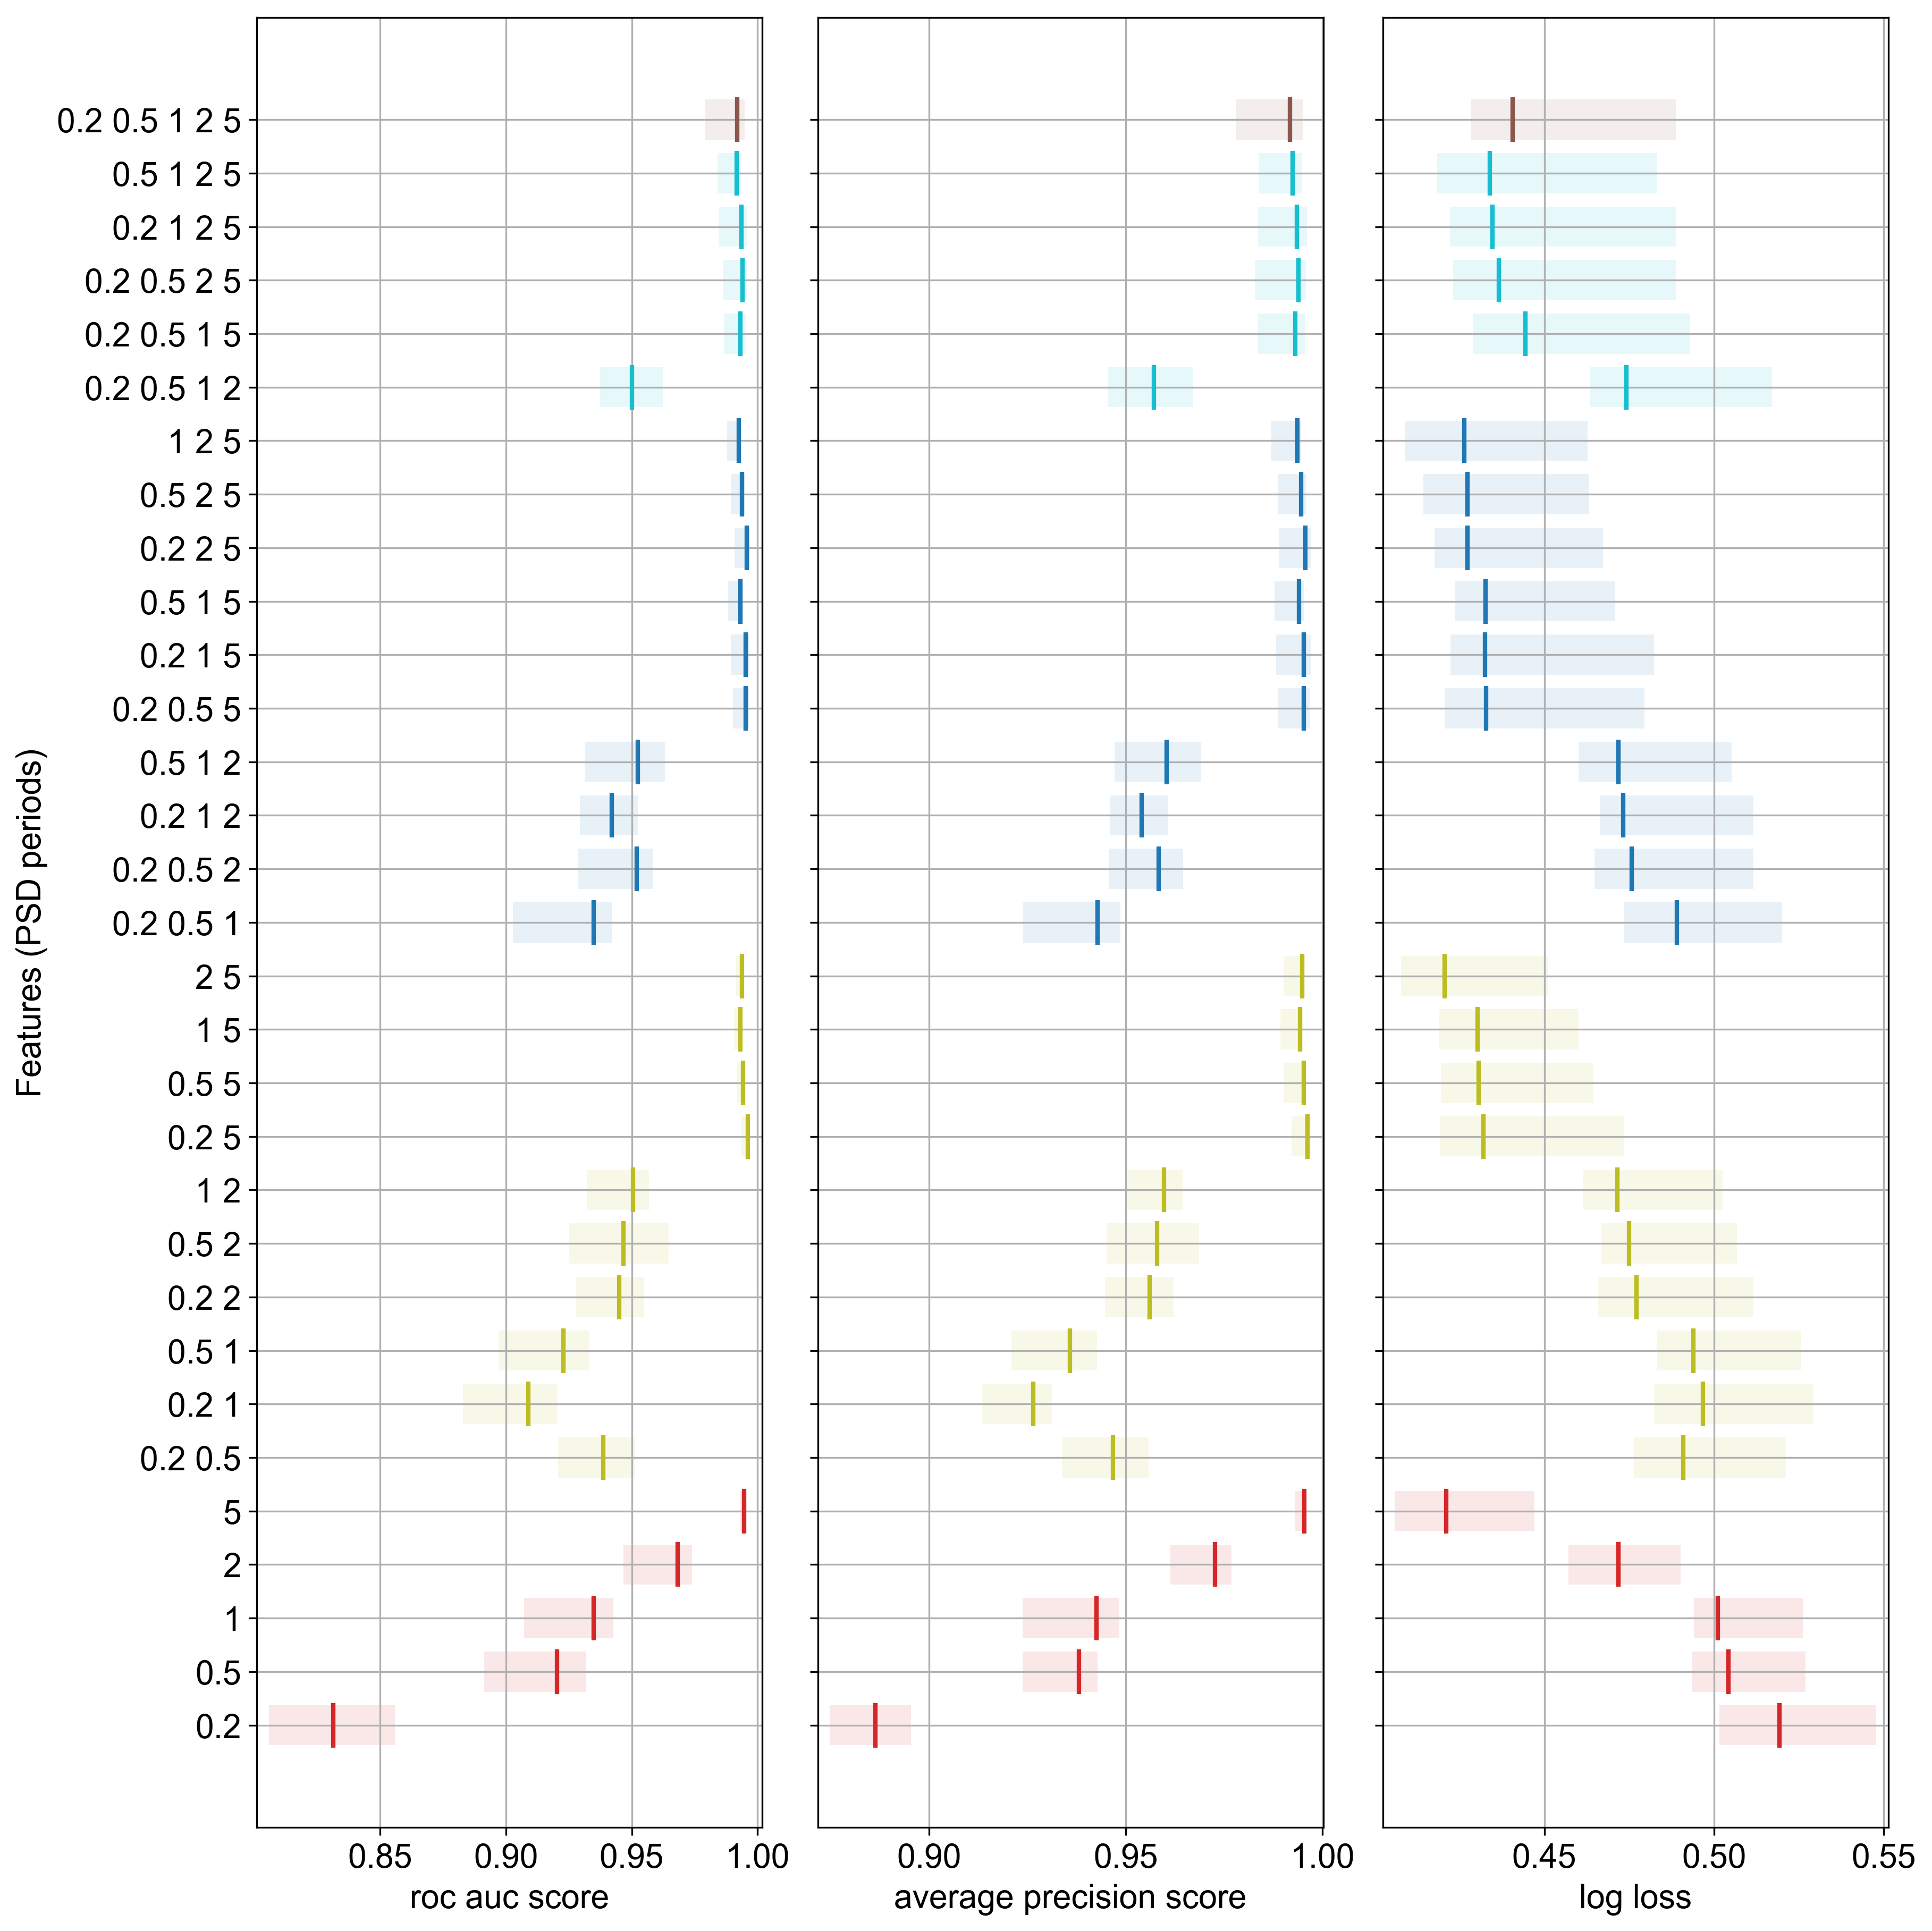

In [4]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'
printhtml('<h3>Evaluation metrics (all classifiers) by number of features</h3>')
_ = plot_scores(sem_df)
plt.show()

Evaluation metrics on best feature(s) by max_samples and n_estimators

(best feature(s) inferred from plot above and are/is: ['psd@5sec', 'psd@0.2sec,psd@5sec', 'psd@0.5sec,psd@5sec', 'psd@1sec,psd@5sec', 'psd@2sec,psd@5sec', 'psd@0.2sec,psd@0.5sec,psd@5sec', 'psd@0.2sec,psd@1sec,psd@5sec', 'psd@0.5sec,psd@1sec,psd@5sec', 'psd@0.2sec,psd@2sec,psd@5sec', 'psd@0.5sec,psd@2sec,psd@5sec', 'psd@1sec,psd@2sec,psd@5sec', 'psd@0.2sec,psd@0.5sec,psd@1sec,psd@5sec', 'psd@0.2sec,psd@0.5sec,psd@2sec,psd@5sec', 'psd@0.2sec,psd@1sec,psd@2sec,psd@5sec', 'psd@0.5sec,psd@1sec,psd@2sec,psd@5sec', 'psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec'])


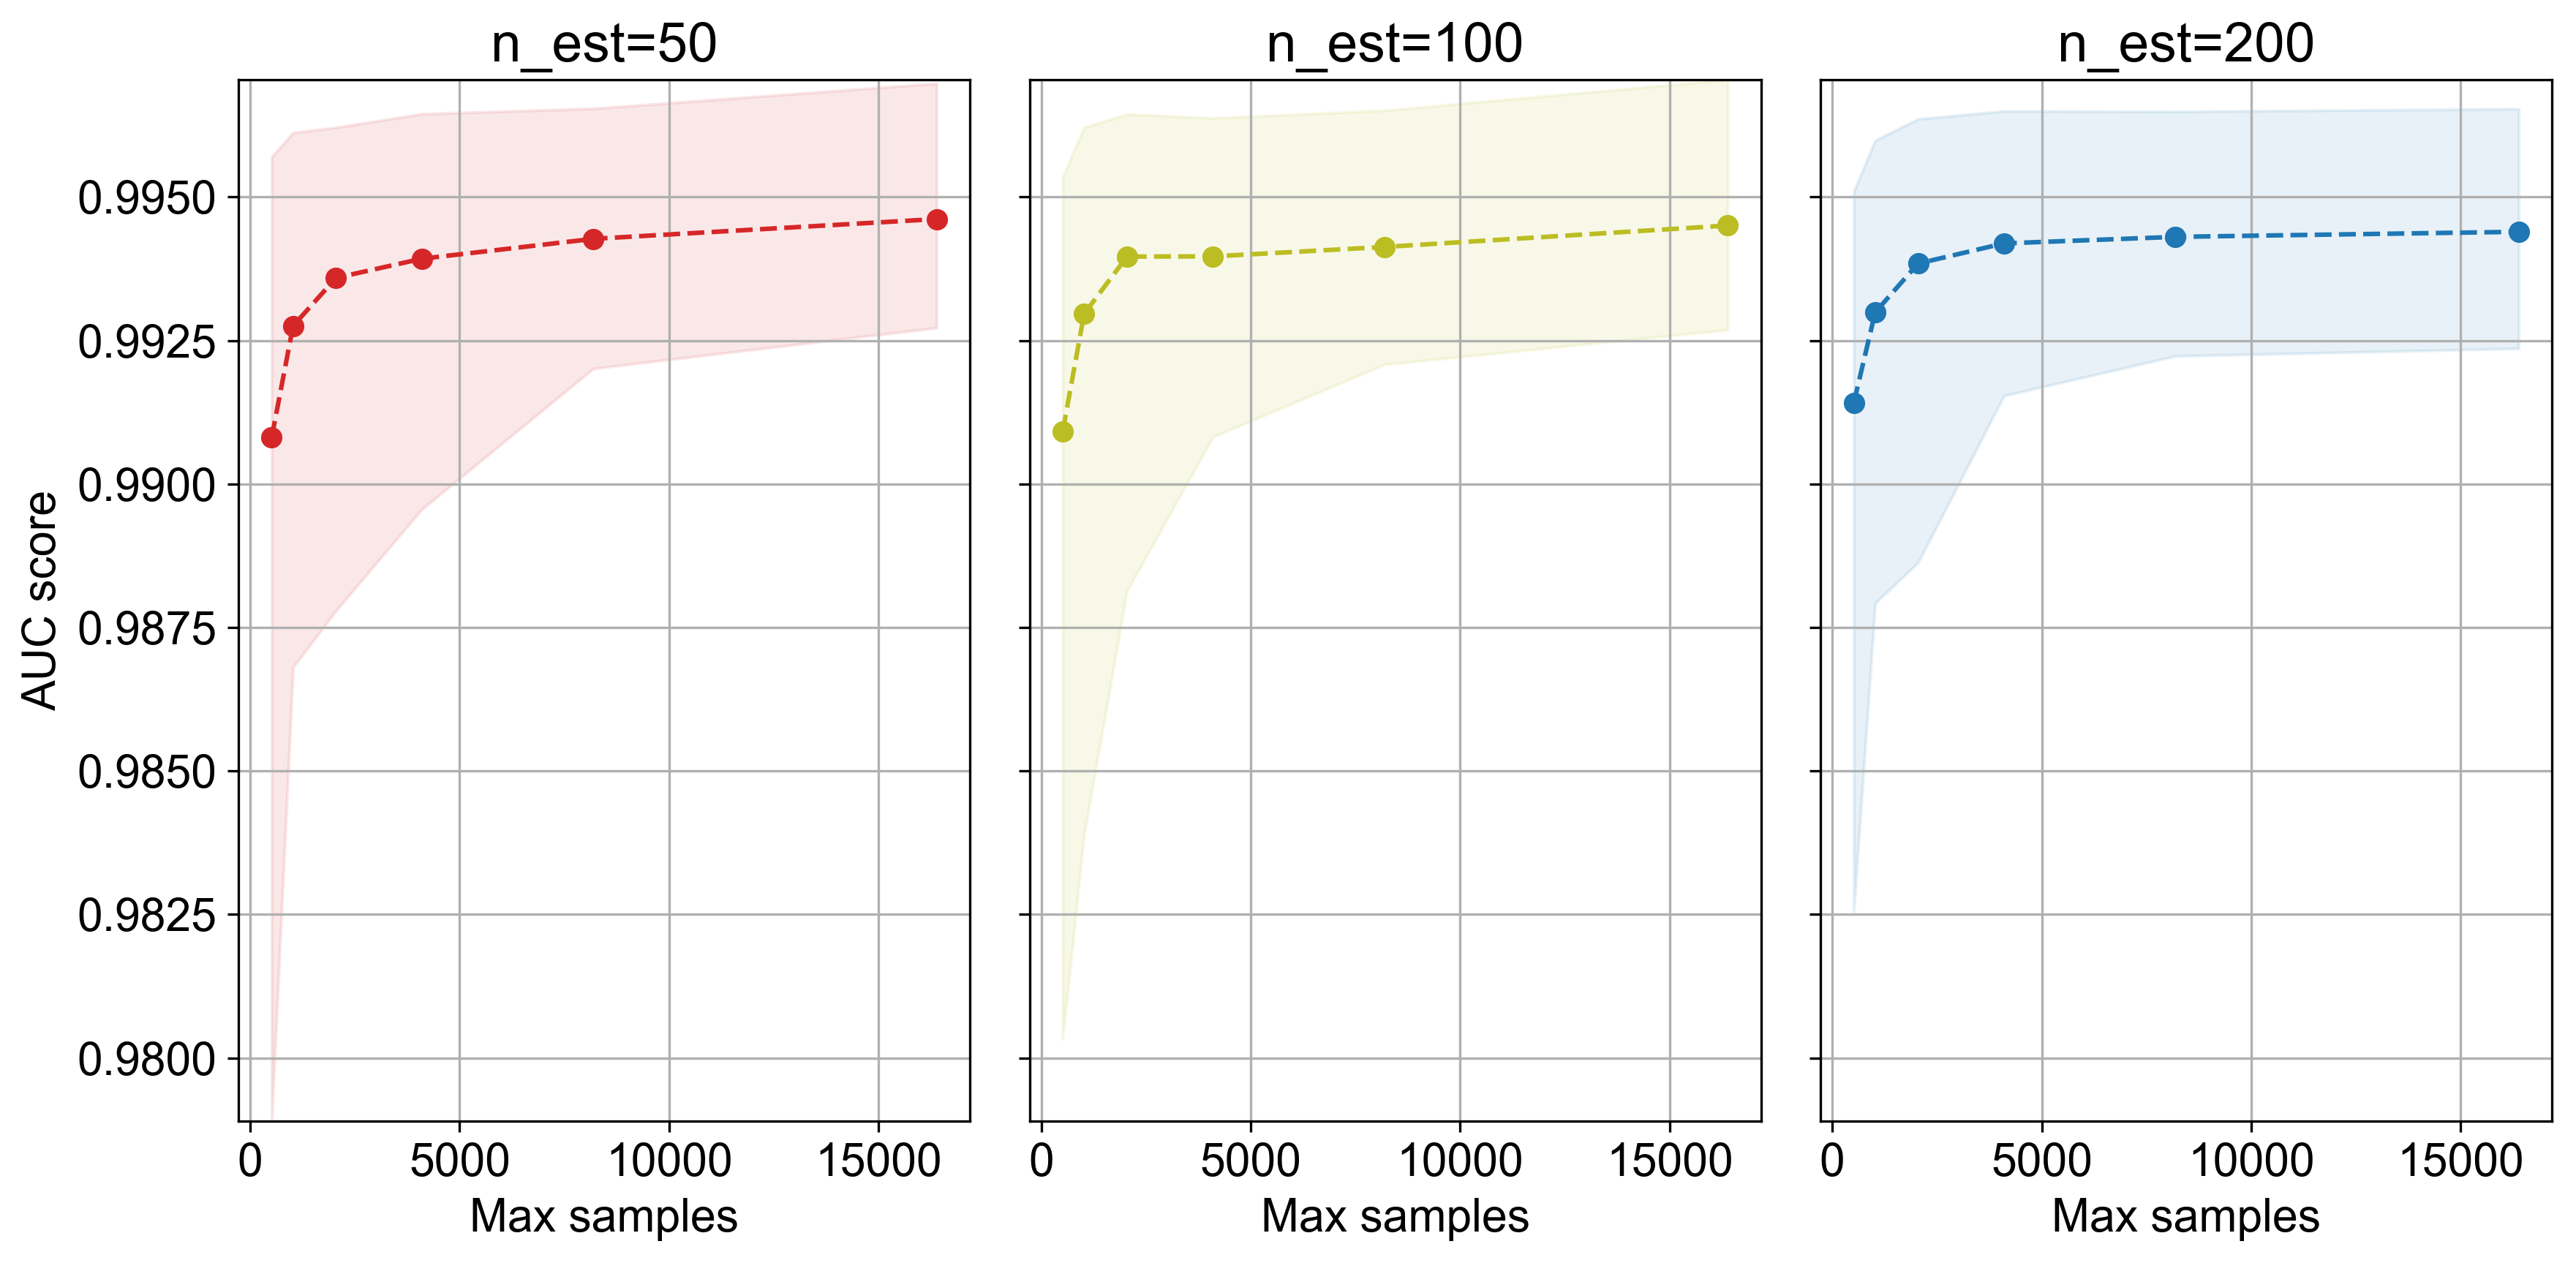

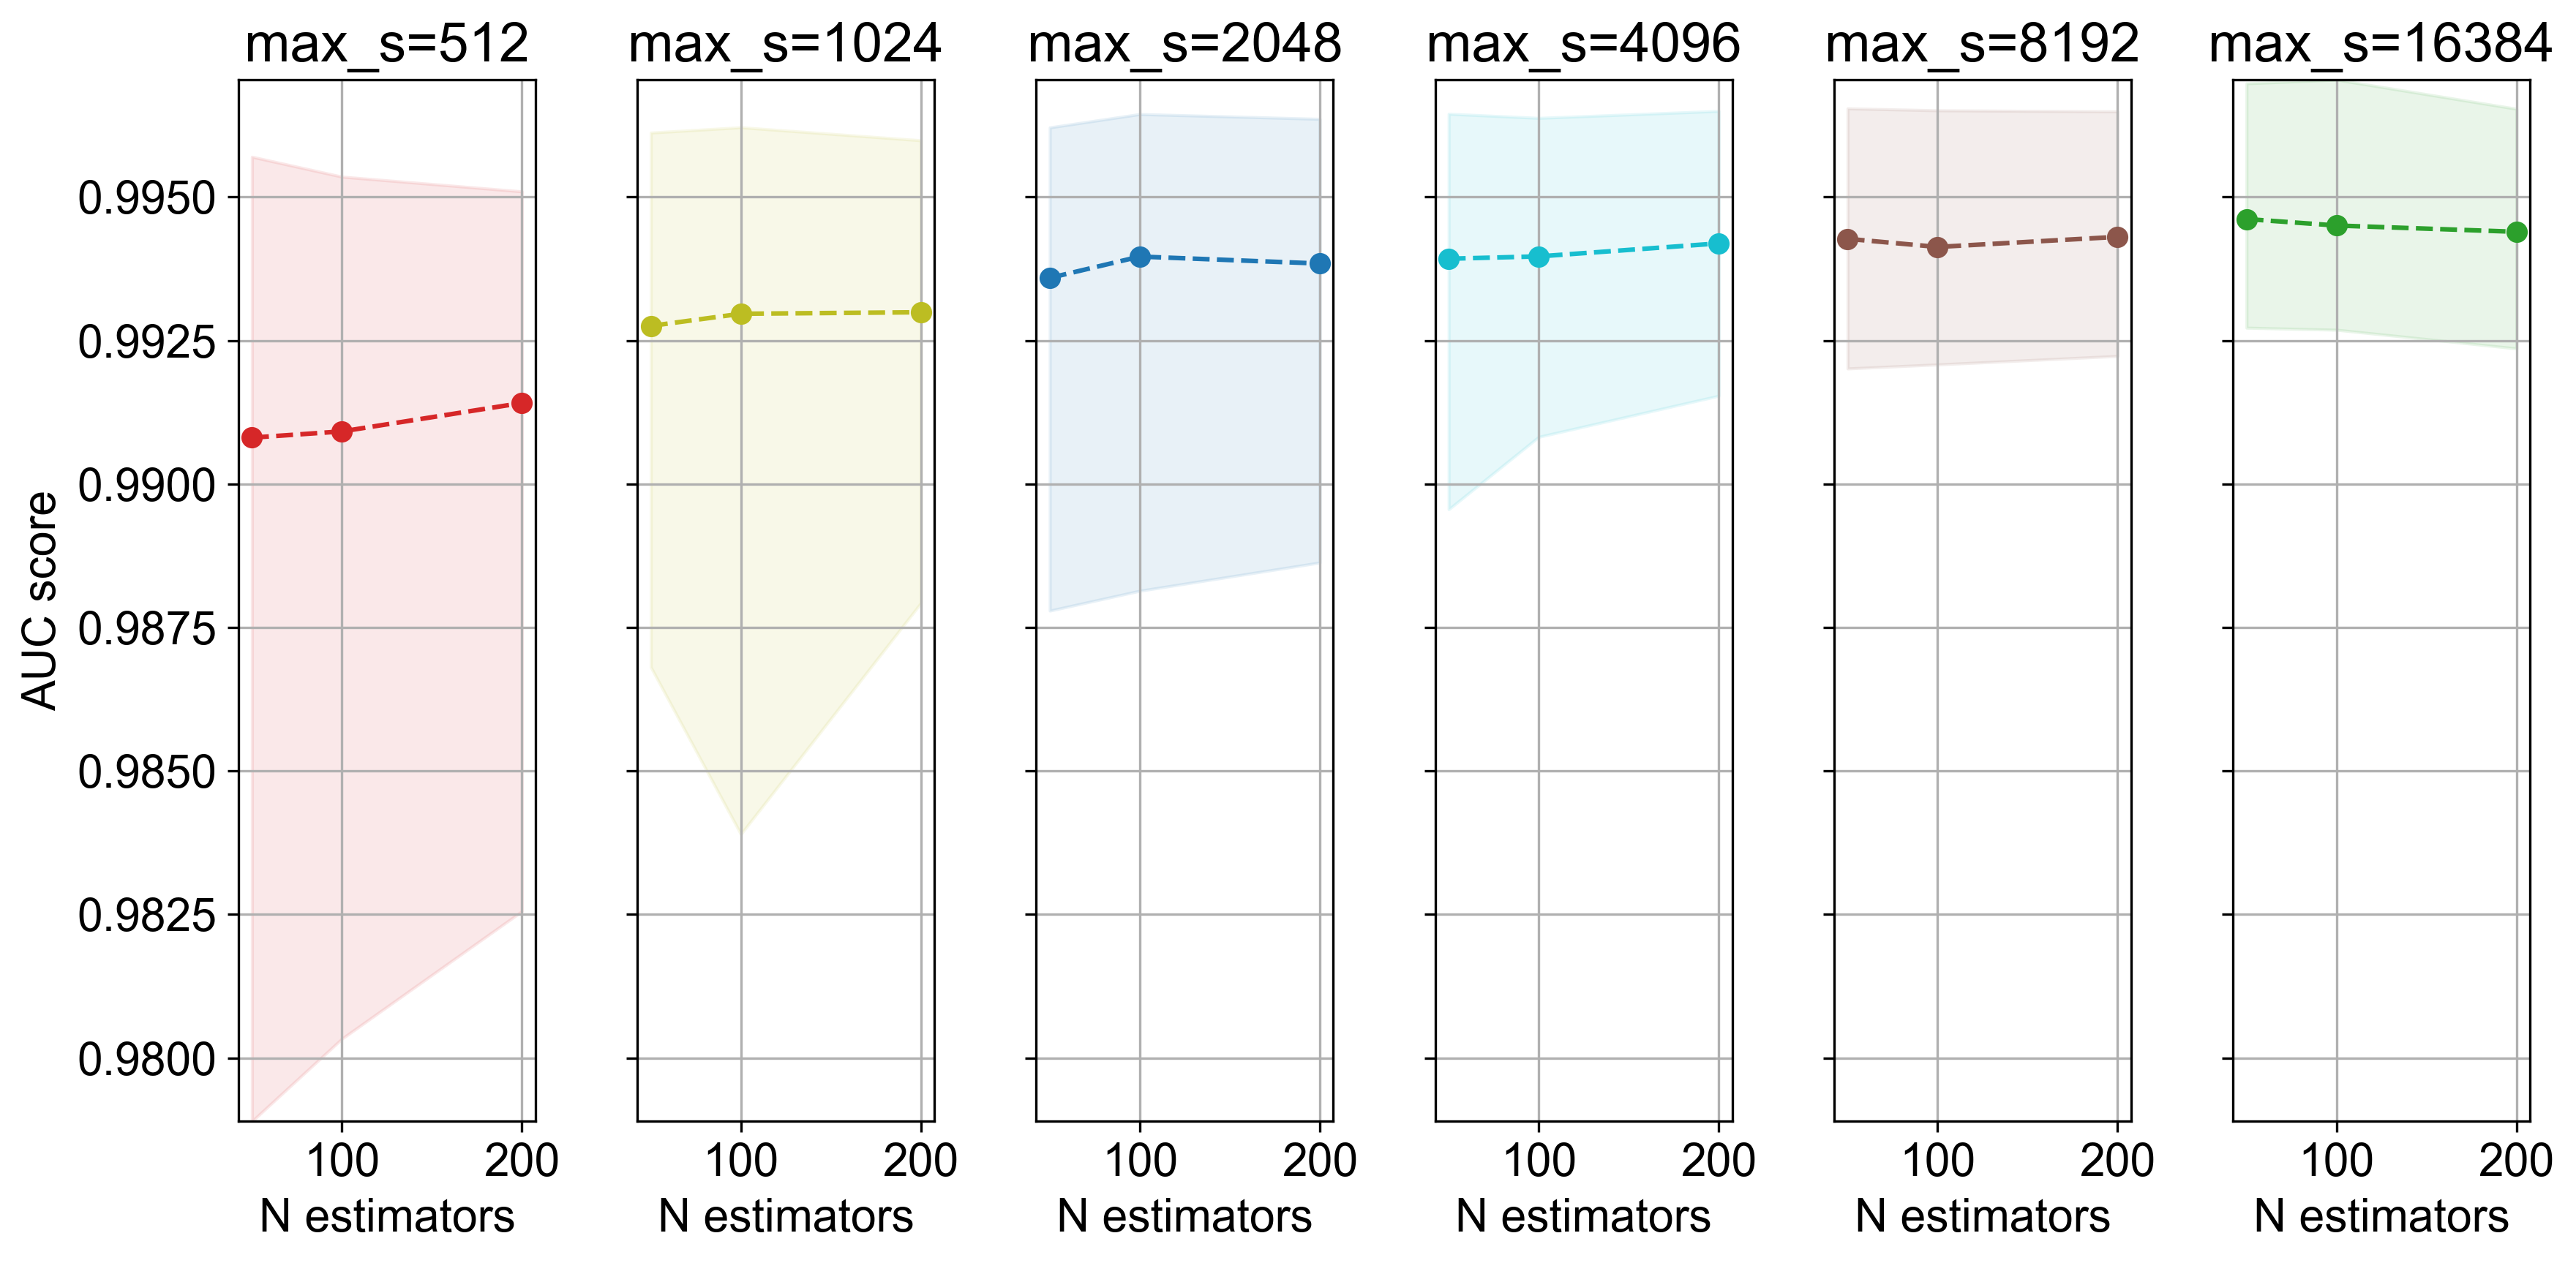


Median roc auc values for best features only
x axis: max_samples, y axis: n_estimators


,512,1024,2048,4096,8192,16384
50,0.990808,0.992755,0.993591,0.993925,0.994271,0.994616
100,0.990916,0.992966,0.993962,0.993965,0.994130,0.994503
200,0.991411,0.992992,0.993841,0.994192,0.994306,0.994394


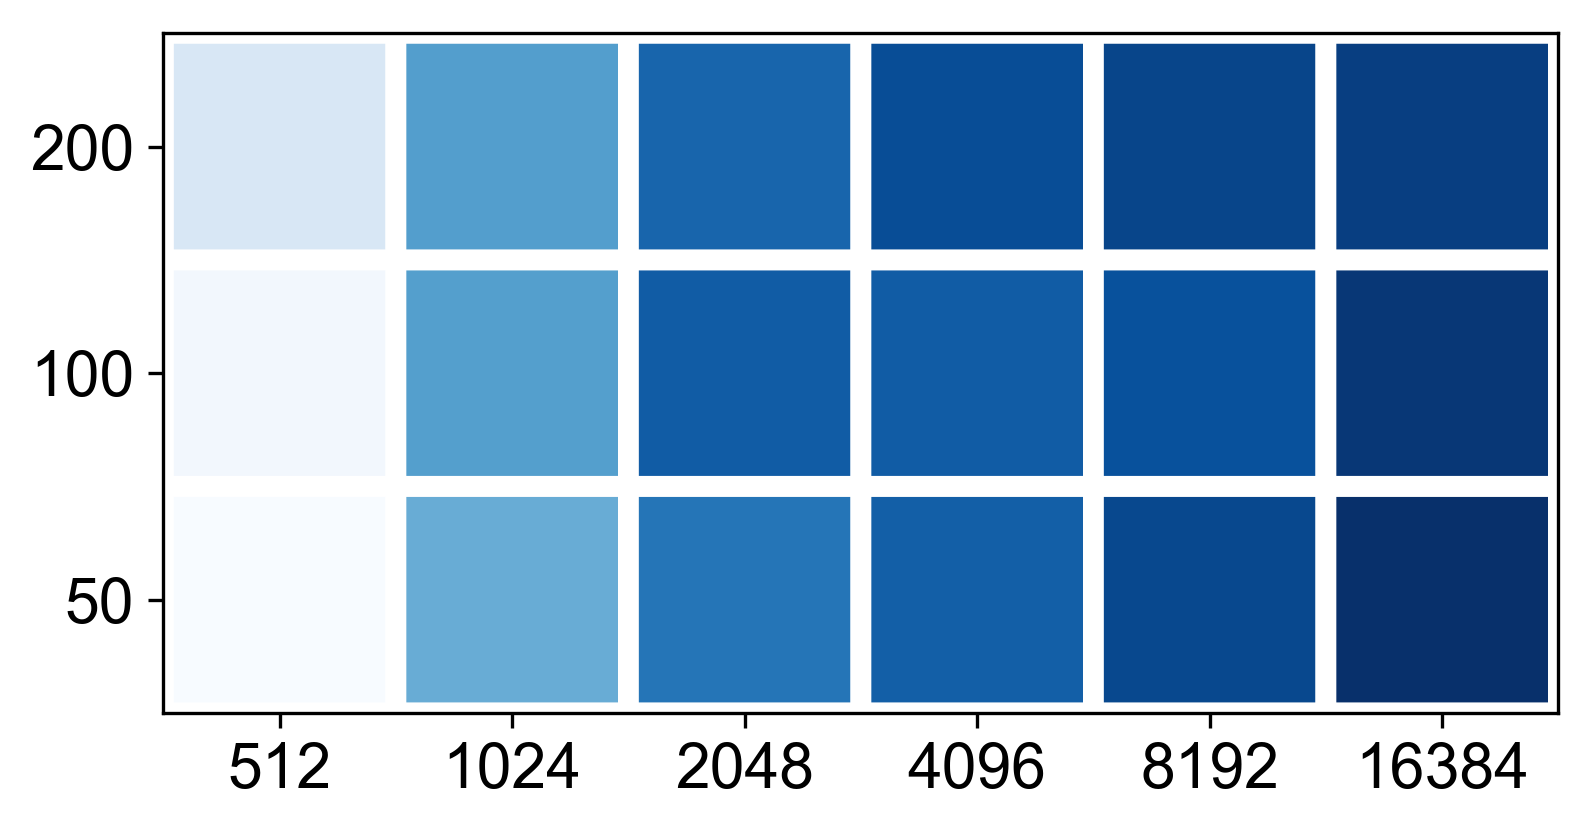


Max roc auc values for best features only
x axis: max_samples, y axis: n_estimators


,512,1024,2048,4096,8192,16384
50,0.995701,0.996122,0.996212,0.996449,0.996543,0.996980
100,0.995354,0.996214,0.996444,0.996377,0.996510,0.997044
200,0.995097,0.995987,0.996361,0.996498,0.996491,0.996536


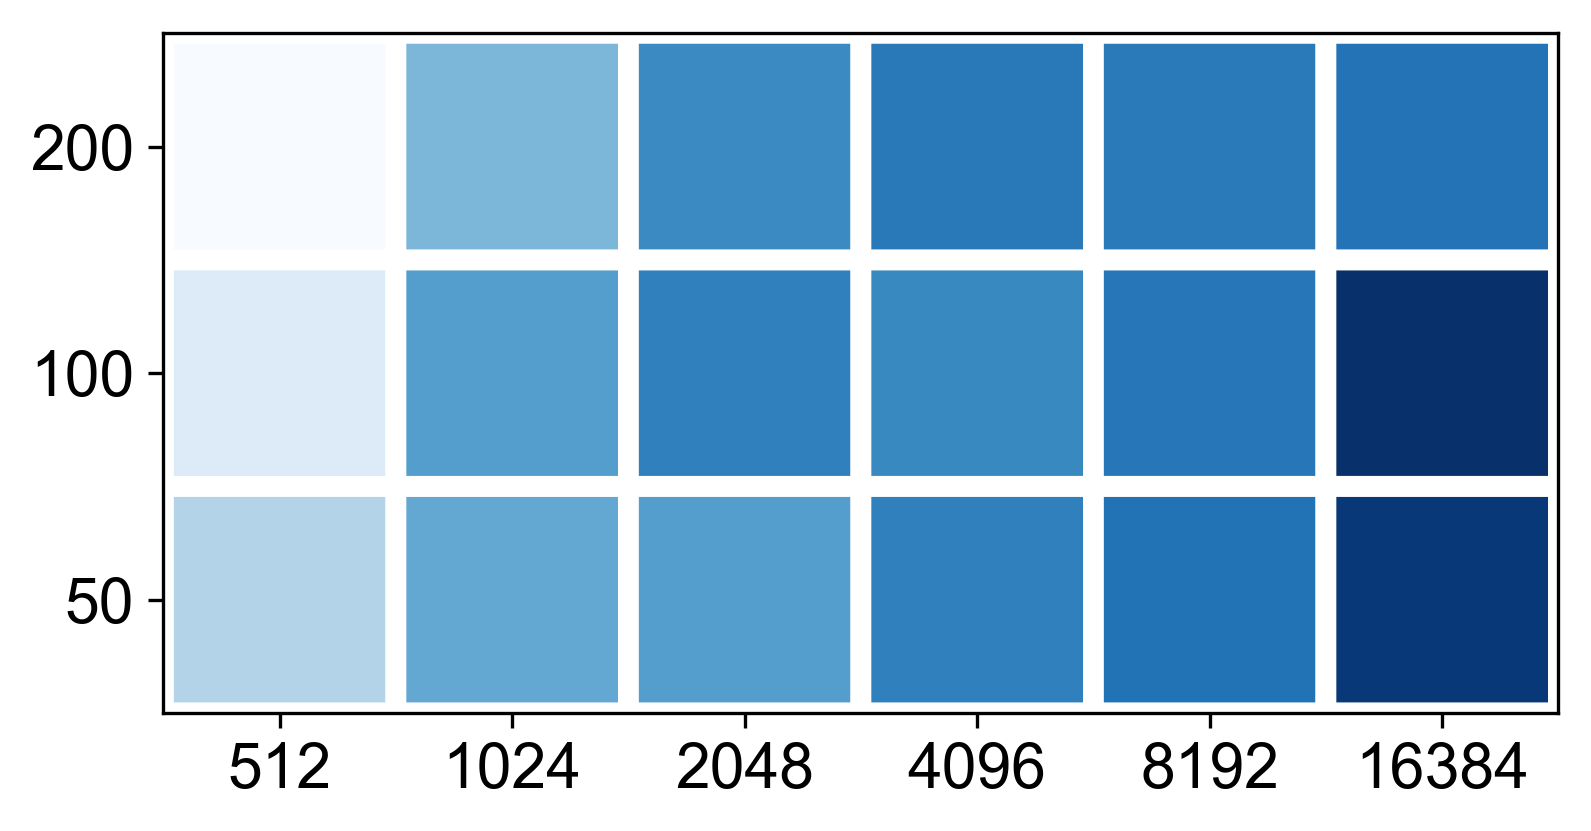


Stdev roc auc values for best features only
x axis: max_samples, y axis: n_estimators


,512,1024,2048,4096,8192,16384
50,0.003325,0.002258,0.001881,0.001623,0.001180,0.001146
100,0.003060,0.002094,0.001655,0.001337,0.001164,0.001185
200,0.002693,0.001662,0.001524,0.001246,0.001132,0.001131


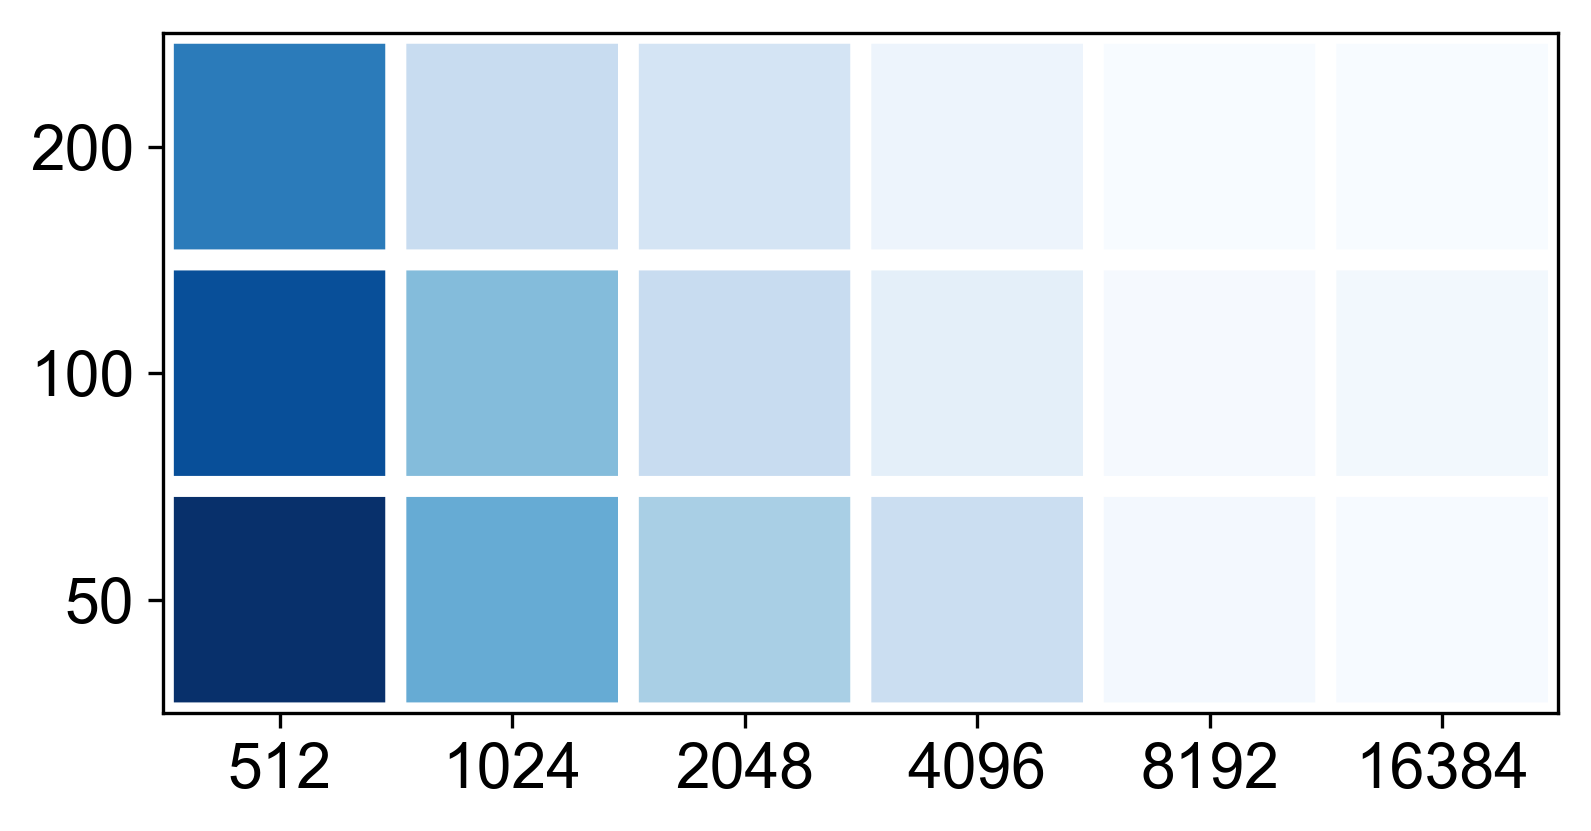

In [5]:
# from sod.core.metrics import harmonic_mean
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 15
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

n_estim = hyperparams['n_estimators']
max_samp = hyperparams['max_samples']


BESTFEATS = [_ for _ in feats if 'psd@5sec' in _] # list(feats)  # ['psd@5sec', 'psd@0.2sec,psd@5sec', 'psd@0.5sec,psd@5sec', 'psd@1sec,psd@5sec', 'psd@2sec,psd@5sec']
# ['psd@5sec', 'psd@2sec,psd@5sec', 'psd@0.2sec,psd@2sec,psd@5sec']  # ['psd@5sec']  # 


printhtml('<h3>Evaluation metrics on best feature(s) by max_samples and n_estimators</h3>')
print('(best feature(s) inferred from plot above and are/is: %s)' % BESTFEATS)

# df_hmean = pd.DataFrame(data=0, index=n_estim, columns=max_samp)
df_median = pd.DataFrame(data=0, index=n_estim, columns=max_samp)
df_max = pd.DataFrame(data=0, index=n_estim, columns=max_samp)
df_min = pd.DataFrame(data=0, index=n_estim, columns=max_samp)
df_var = pd.DataFrame(data=0, index=n_estim, columns=max_samp)

for n_estimators in n_estim:
    for max_samples in max_samp:
        df = sem_df[
            sem_df.feats.isin(BESTFEATS) &
            (sem_df.n_estimators == n_estimators) &
            (sem_df.max_samples == max_samples)
        ]
        assert np.true_divide(len(df), len(hyperparams['random_state'])) == int(np.true_divide(len(df), len(hyperparams['random_state'])))
        vals = df.roc_auc_score
        # df_hmean.loc[n_estimators, max_samples] = np.true_divide(len(vals), np.sum(1.0/ vals))
        df_median.loc[n_estimators, max_samples] = vals.median()
        df_max.loc[n_estimators, max_samples] = vals.max()
        df_min.loc[n_estimators, max_samples] = vals.min()
        df_var.loc[n_estimators, max_samples] = vals.std()

        
def plotheatmap(df, title=None):
    plt.pcolor(df, cmap='Blues', edgecolor='white', linewidth=5)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.gcf().set_size_inches(len(df.columns), len(df.index))
    if title:
        plt.title(title)
    plt.show()


fig, axes = plt.subplots(1, len(df_median.index))
fig.set_size_inches((12, 6))
for i, n_e in enumerate(df_median.index):
    ax = axes[i]
    x = df_median.columns.values.astype(float)
    miny = df_min[df_min.index == n_e].values.flatten()
    mediany = df_median[df_min.index == n_e].values.flatten()
    maxy = df_max[df_max.index == n_e].values.flatten()
    ax.fill_between(x, miny, maxy, alpha=0.1, color=basecolors[i])
    ax.plot(x, mediany, linestyle='--', color=basecolors[i], label='n_est=' + str(n_e), marker='o')
    ax.set_title('n_est=' + str(n_e))
    ax.set_xlabel('Max samples')
    ax.set_ylim(df_min.values.min(), df_max.values.max())
    ax.grid()
    if i == 0:
        ax.set_ylabel('AUC score')
    else:
        ax.set_yticklabels([])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel('Max samples')
# plt.ylabel('AUC score')
# plt.grid()
plt.tight_layout(rect=[0,0,1,1])
plt.show()


fig, axes = plt.subplots(1, len(df_median.columns))
fig.set_size_inches((12, 6))
for i, m_s in enumerate(df_median.columns):
    ax = axes[i]
    x = df_median.index.values.astype(float)
    miny = df_min[[m_s]].values.flatten()
    mediany = df_median[[m_s]].values.flatten()
    maxy = df_max[[m_s]].values.flatten()
    ax.fill_between(x, miny, maxy, alpha=0.1, color=basecolors[i])
    ax.plot(x, mediany, linestyle='--', color=basecolors[i], label='max_s=' + str(m_s), marker='o')
    ax.set_title('max_s=' + str(m_s))
    ax.set_xlabel('N estimators')
    ax.set_ylim(df_min.values.min(), df_max.values.max())
    ax.grid()
    if i == 0:
        ax.set_ylabel('AUC score')
    else:
        ax.set_yticklabels([])
plt.tight_layout(rect=[0,0,1,1])
plt.show()


print()
print('Median roc auc values for best features only')
print('x axis: max_samples, y axis: n_estimators')
display(df_median)
plotheatmap(df_median)


print()
print('Max roc auc values for best features only')
print('x axis: max_samples, y axis: n_estimators')
display(df_max)
plotheatmap(df_max)


print()
print('Stdev roc auc values for best features only')
print('x axis: max_samples, y axis: n_estimators')
display(df_var)
plotheatmap(df_var)

In [6]:

def plotpred(pred_dfs, roc_xlim=None, roc_ylim=None, pr_xlim=None, pr_ylim=None):
    plt.rcParams['figure.figsize'] = (12, 12)
    plt.rcParams['font.size'] = 10

    pred_dfs2 = pred_dfs
    # get best row/col grid:
    _ = np.ceil(np.sqrt(len(pred_dfs2)))
    assert _ ** 2 >= len(pred_dfs2)
    # fix rows and cols as the given _ number
    rows, cols = int(_), int(_)
    # for some cases (e.g. len(pred_dfs2)==12) we have rows = cols = 4, whereas rows could be 3
    # Do a simple stupid check to see if we can decrement rows:
    while True:
        if (cols - 1) * rows >= len(pred_dfs2):
            cols -= 1
        else:
            break


    # ======================================
    # print scores distributions
    # ======================================
    bins = 10
    printhtml('<h3>Segments frequency distribution per score</h3>')
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(rows, cols)
    idx = 0
    for idx, (title, pred_df) in enumerate(pred_dfs2.items()):
        r, c = int(idx // cols), int(idx % cols)
        ax = fig.add_subplot(gs[r, c])
        ax.hist(
            [pred_df[~pred_df.outlier].predicted_anomaly_score, pred_df[pred_df.outlier].predicted_anomaly_score],
            density=False,
            bins=bins,
            label=['inliers', 'outliers'], log=False, stacked=False, rwidth=.5
        )
        title = title.replace('psd@', '').replace('sec', '').replace('\n', ' ')
        ax.set_title(title)
        if r < rows - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Score')
        if c !=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('#inst.')
        ax.grid()
    samex(fig.axes)
    samey(fig.axes)
    # fig.tight_layout(rect=[0,0,1,1])
    plt.show()


    # ======================================
    # print scores distributions %
    # ======================================
    step = 0.05
    bins = np.arange(0.35, 0.95, step)
    # bins = [0, 0.4] + [[_, _+ step] for i in np.arange(0.4, 0.85, step)] + [0.85, 1.1]
    xlabels = ["[%.2f, %.2f)" % (_, _ + step) for _ in bins]
    xticks = np.arange(len(bins))
    printhtml('<h3>Segments ratio per score (% of the relative class count)</h3>')
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(rows, cols)
    idx = 0
    for idx, (title, pred_df) in enumerate(pred_dfs2.items()):
        r, c = int(idx // cols), int(idx % cols)
        ax = fig.add_subplot(gs[r, c])
        i_scores, o_scores = [], []
        for b in bins:
            scores = pred_df.predicted_anomaly_score
            total = ((scores >= b) & (scores < b+step)).sum()
            i_score, o_score = 0, 0
            if total > 0:
                scores = pred_df[~pred_df.outlier].predicted_anomaly_score
                i_score = np.true_divide(((scores >= b) & (scores < b+step)).sum(), total)
                scores = pred_df[pred_df.outlier].predicted_anomaly_score
                o_score = np.true_divide(((scores >= b) & (scores < b+step)).sum(), total)
            i_scores.append(100 * i_score)
            o_scores.append(100 * o_score)
        ax.plot(xticks, i_scores, marker='o', linewidth=2, label=['inlier'])
        ax.plot(xticks, o_scores, marker='o', linewidth=2, label=['outlier'])
        title = title.replace('psd@', '').replace('sec', '').replace('\n', ' ')
        ax.set_title(title)
        if r < rows - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Score')
            ax.set_xticks(xticks)
            ax.set_xticklabels(xlabels, rotation='vertical')
        if c !=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('inst.rate(%)')
        ax.grid()
    samex(fig.axes)
    samey(fig.axes)
    # fig.tight_layout(rect=[0,0,1,1])
    plt.show()

    
    from sod.core.metrics import roc_curve, roc_auc_score
    printhtml('<h3>Roc curves</h3>')
    # ======================================
    # print auc scores
    # ======================================
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(rows, cols)
    idx = 0
    for idx, (title, pred_df) in enumerate(pred_dfs2.items()):
        r, c = int(idx // cols), int(idx % cols)
        ax = fig.add_subplot(gs[r, c])
        fpr, tpr, thresholds, best_th_index, best_th = roc_curve(pred_df)
        ax.plot(
            fpr, tpr, linewidth=2
        )
        title = title.replace('psd@', '').replace('sec', '').replace('\n', ' ') +\
            '\nROC_AUC: %.4f' % roc_auc_score(pred_df)
        ax.set_title(title)
        if r < rows - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('FPR')
        if c !=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('TPR')
        ax.grid()
        if roc_xlim is not None:
            ax.set_xlim(roc_xlim)
        if roc_ylim is not None:
            ax.set_ylim(roc_ylim)
    if roc_xlim is None:
        samex(fig.axes)
    if roc_ylim is None:
        samey(fig.axes)
    # fig.tight_layout(rect=[0,0,1,1])
    plt.show()



    from sod.core.metrics import precision_recall_curve, average_precision_score
    printhtml('<h3>P/R curves</h3>')
    # ======================================
    # print auc scores
    # ======================================
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(rows, cols)
    idx = 0
    for idx, (title, pred_df) in enumerate(pred_dfs2.items()):
        r, c = int(idx // cols), int(idx % cols)
        ax = fig.add_subplot(gs[r, c])
        prec, rec, thresholds, best_th_index, best_th = precision_recall_curve(pred_df)
        ax.plot(
            rec, prec, linewidth=2  #, marker='.'
        )
        title = title.replace('psd@', '').replace('sec', '').replace('\n', ' ') +\
            '\nAPS: %.4f' % average_precision_score(pred_df)
        ax.set_title(title)
        if r < rows - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Recall')
        if c !=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('Precision')
        ax.grid()
        if pr_xlim is not None:
            ax.set_xlim(pr_xlim)
        if pr_ylim is not None:
            ax.set_ylim(pr_ylim)
    if pr_xlim is None:
        samex(fig.axes)
    if pr_ylim is None:
        samey(fig.axes)
    # fig.tight_layout(rect=[0,0,1,1])
    plt.show()

print('Created function plotpred')


Created function plotpred


In [7]:
NUM_BEST_MODELS = 9
groupcolumns = ['feats' ] + list(_ for _ in hyperparams.keys() if _ != 'random_state')
printhtml('<h3>Loading %d best models according to %s</h3>' % (NUM_BEST_MODELS, SCORE))
print('(Models sharing the same values of %s will be grouped and discared except the one with median value score)' % groupcolumns)
print()

sem_df2 = []
for _, df_ in sem_df.groupby(groupcolumns, sort=False):
    # take the (single row) median
    df_ = df_[df_[SCORE]==df_[SCORE].median()][0:1]
    # rename _key to key_key because namedtuples (see sem_df2.itertuples() below) do not accept leading underscores
    df_ = df_.rename({'_key': 'key_key'}, axis=1)
    # append
    sem_df2.append(df_)
sem_df2 = pd.concat(sem_df2, sort=False, ignore_index=True, axis=0, copy=True).sort_values([SCORE], ascending=False)


pbar_percent_step = 25
pbar_percent_mark = pbar_percent_step
pred_dfs = {}
for i, tmp in enumerate(sem_df2.head(NUM_BEST_MODELS).itertuples()):
    preddf_file = os.path.join(maindir, tmp.key_key)
    key_ = 'f=%s\nms=%d\nne=%d' % (str(tmp.feats), tmp.max_samples, tmp.n_estimators)
    pred_dfs[key_] = pd.read_hdf(preddf_file, columns=['outlier', 'predicted_anomaly_score'])
    percent = 100*float(i)/NUM_BEST_MODELS
    if percent >= pbar_percent_mark:
        pbar_percent_mark += pbar_percent_step
        print('Reading... %.0f%% done' % percent)


        
# print('The following files where successfully read: %s' % str(list(os.path.basename(_) for _ in testsetpaths(tmp))))
print('DONE')

Loading 9 best models according to roc_auc_score

(Models sharing the same values of ['feats', 'n_estimators', 'max_samples'] will be grouped and discared except the one with median value score)

Reading... 33% done
Reading... 56% done
Reading... 78% done
DONE


Displaying some EM for the models just loaded

Segments frequency distribution per score

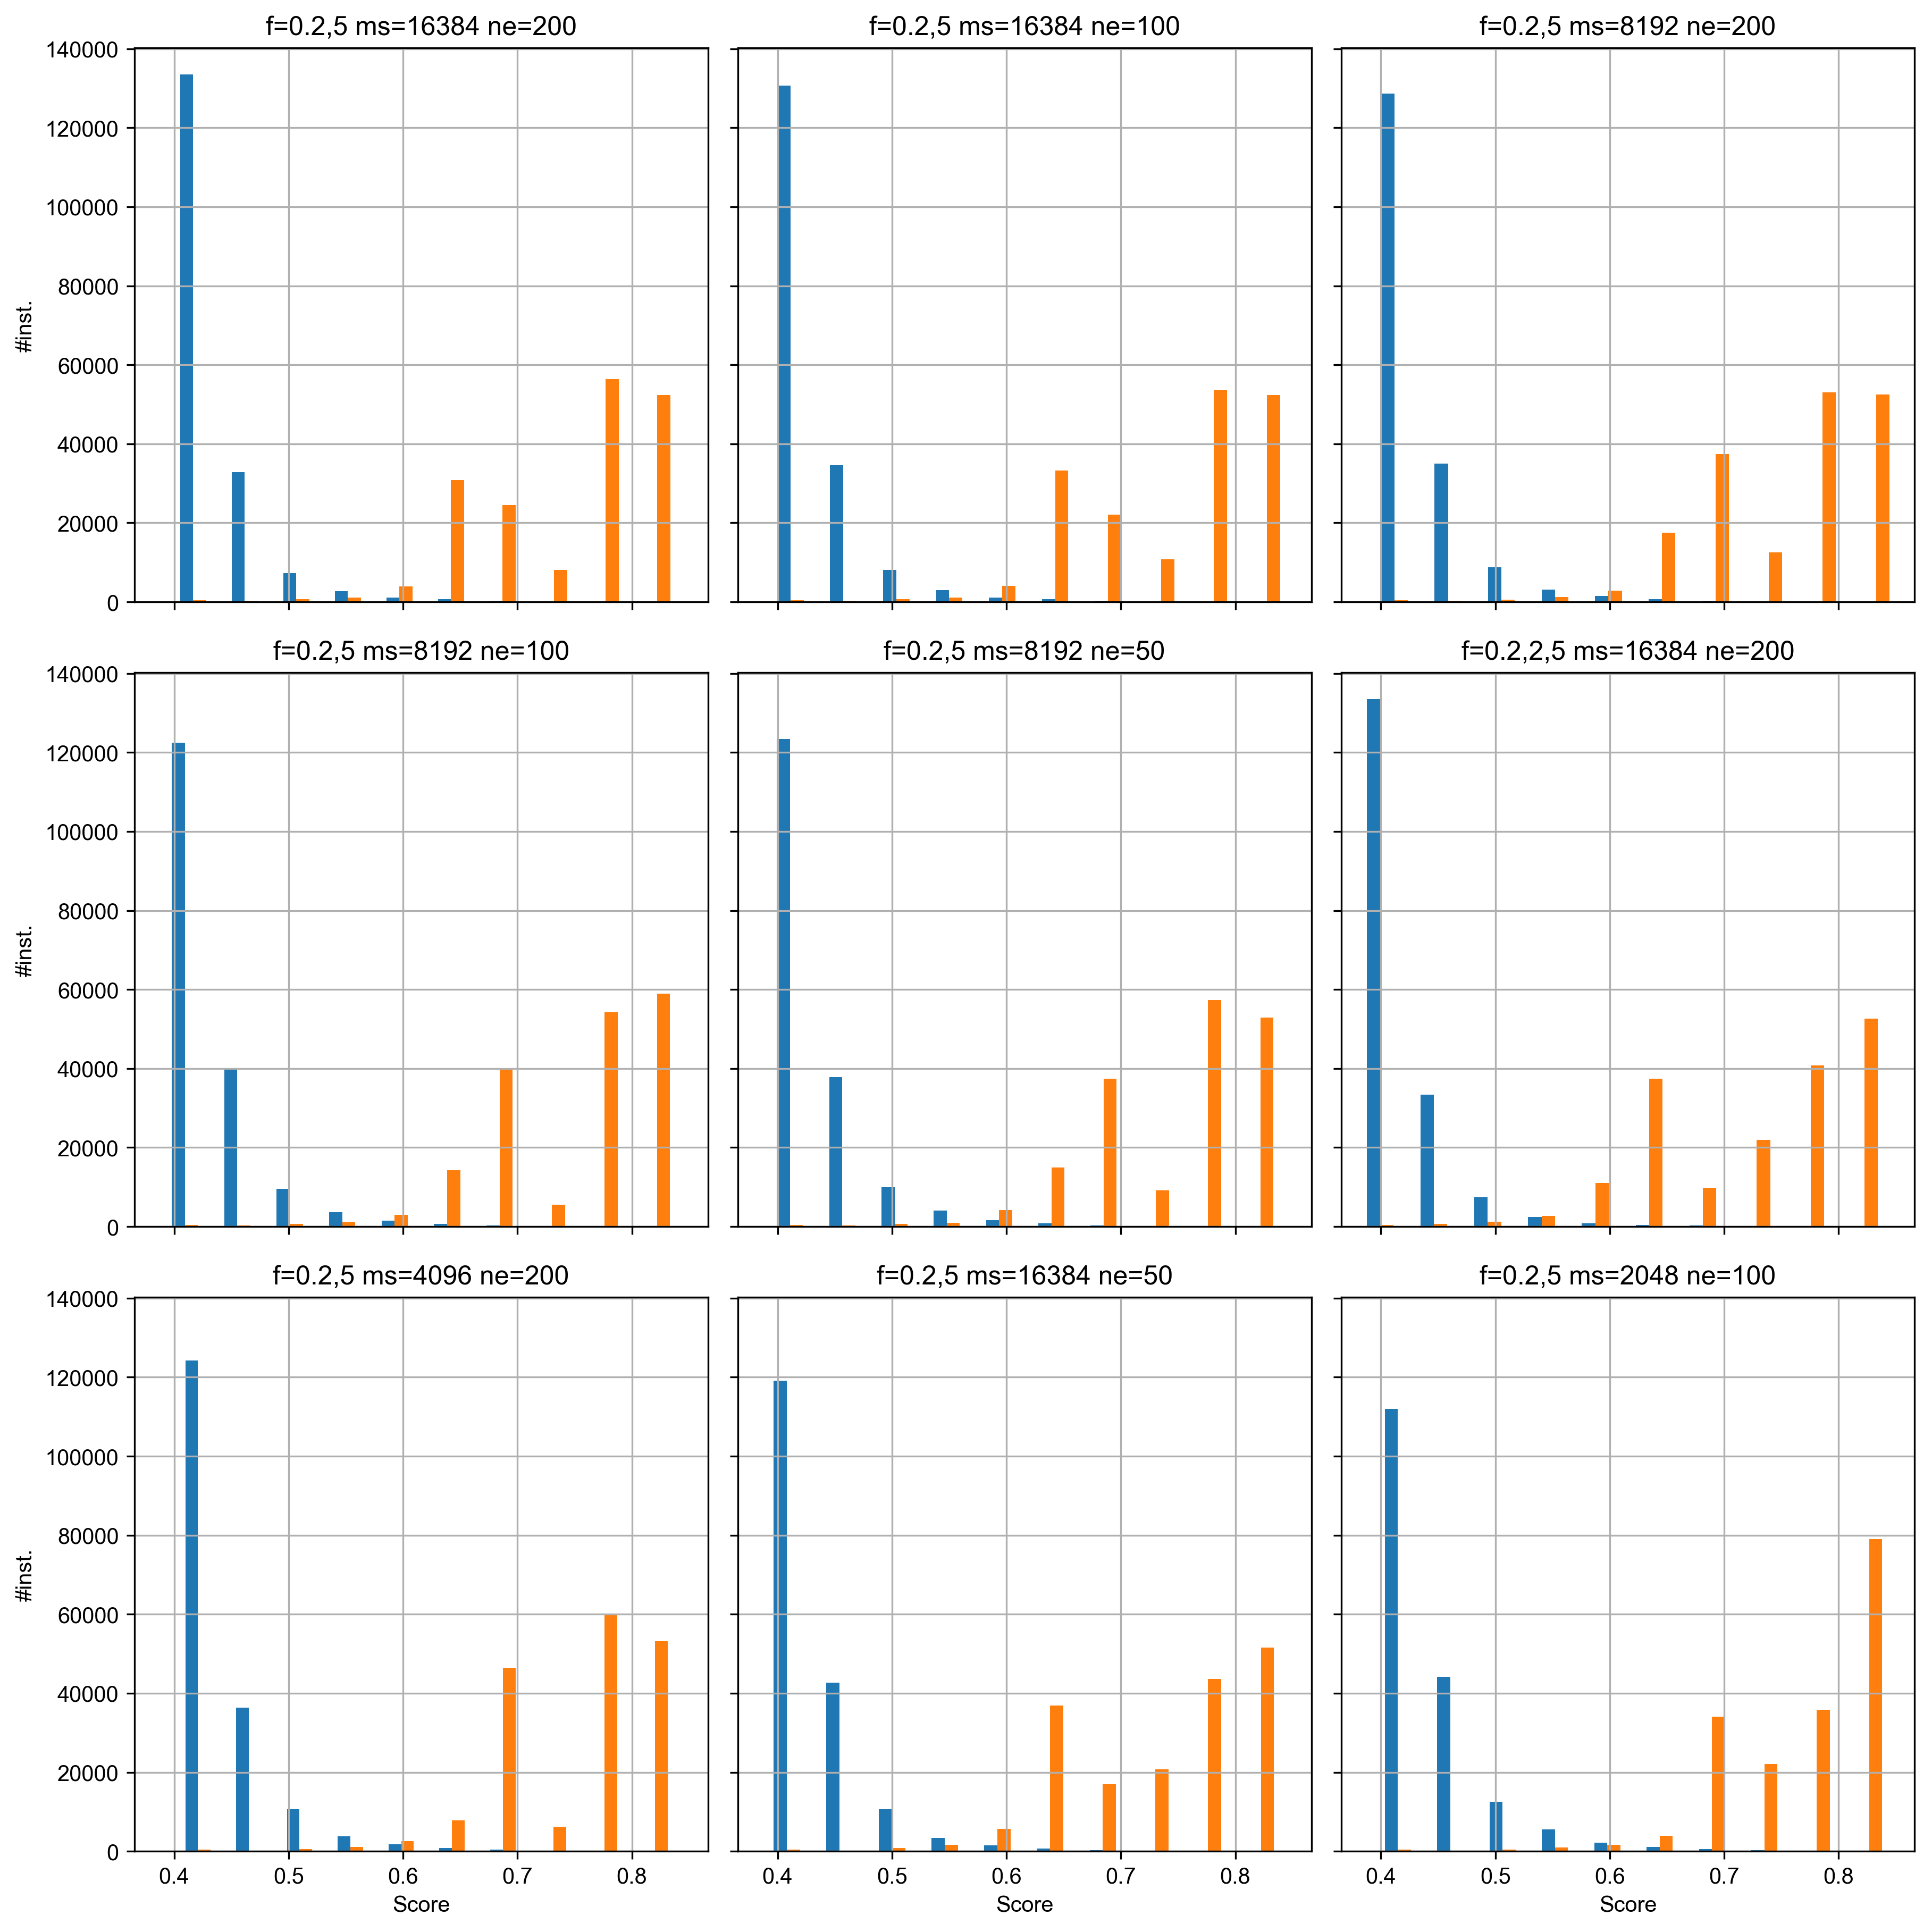

Segments ratio per score (% of the relative class count)

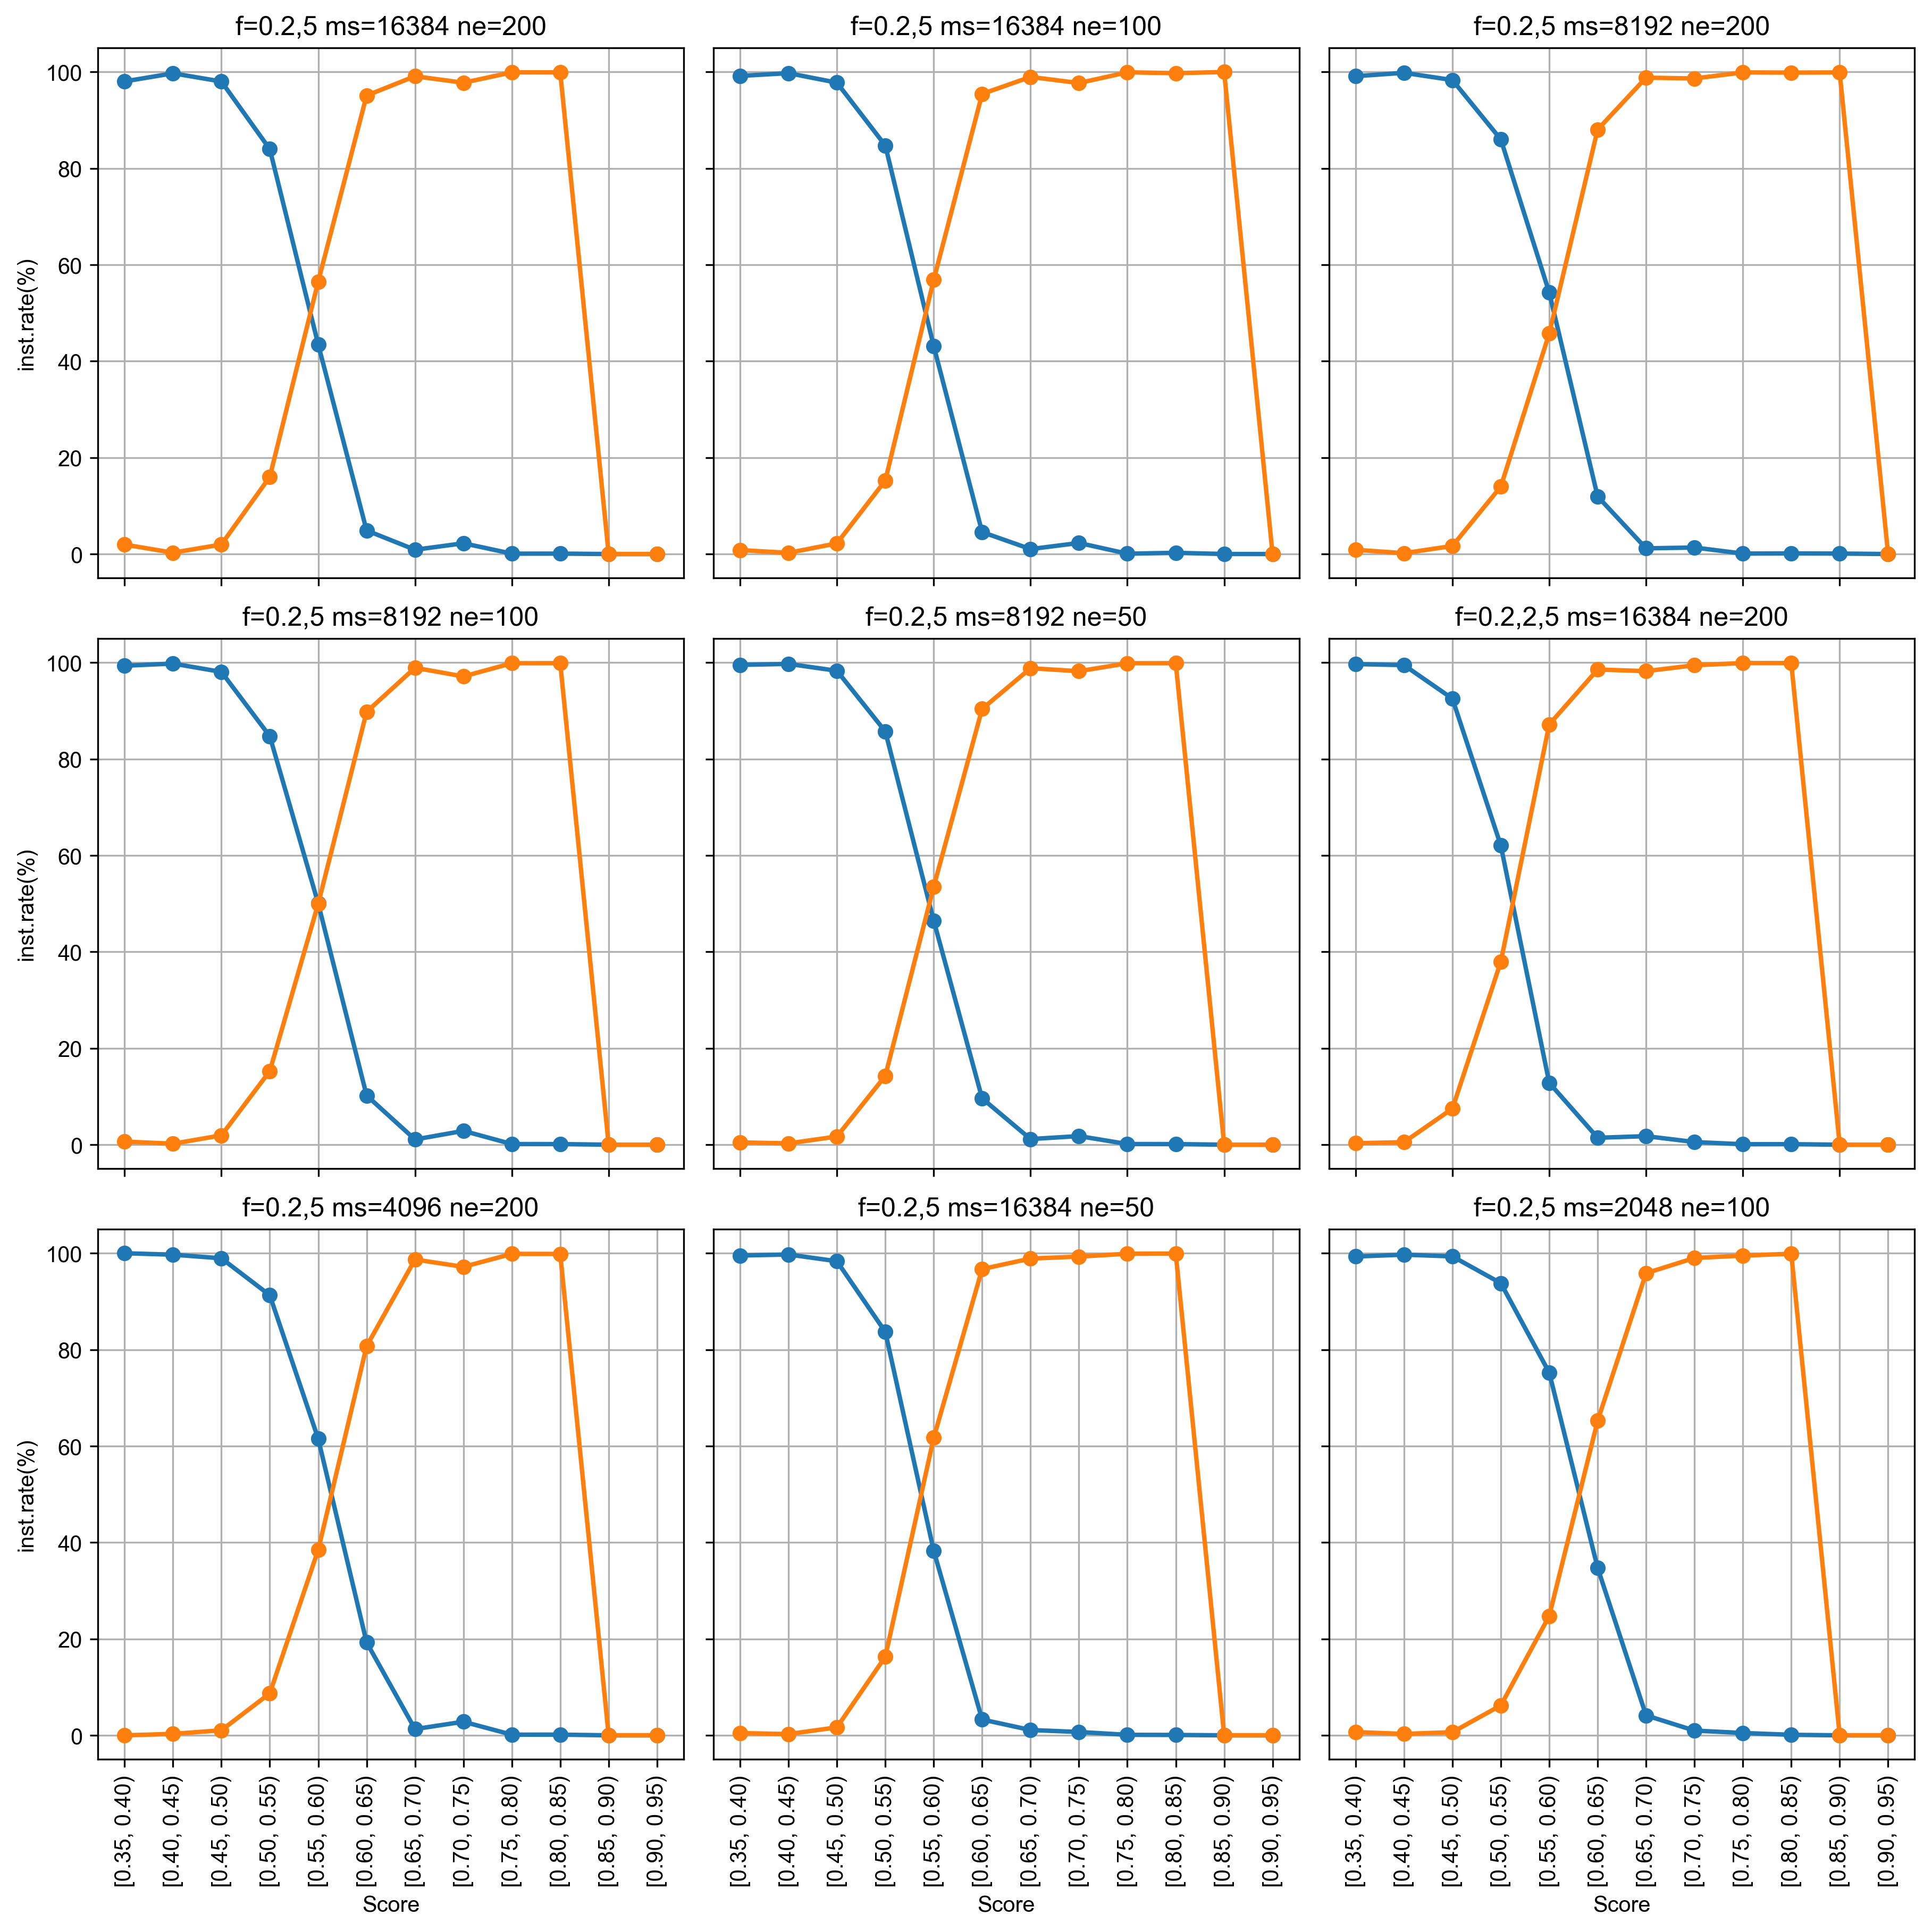

Roc curves

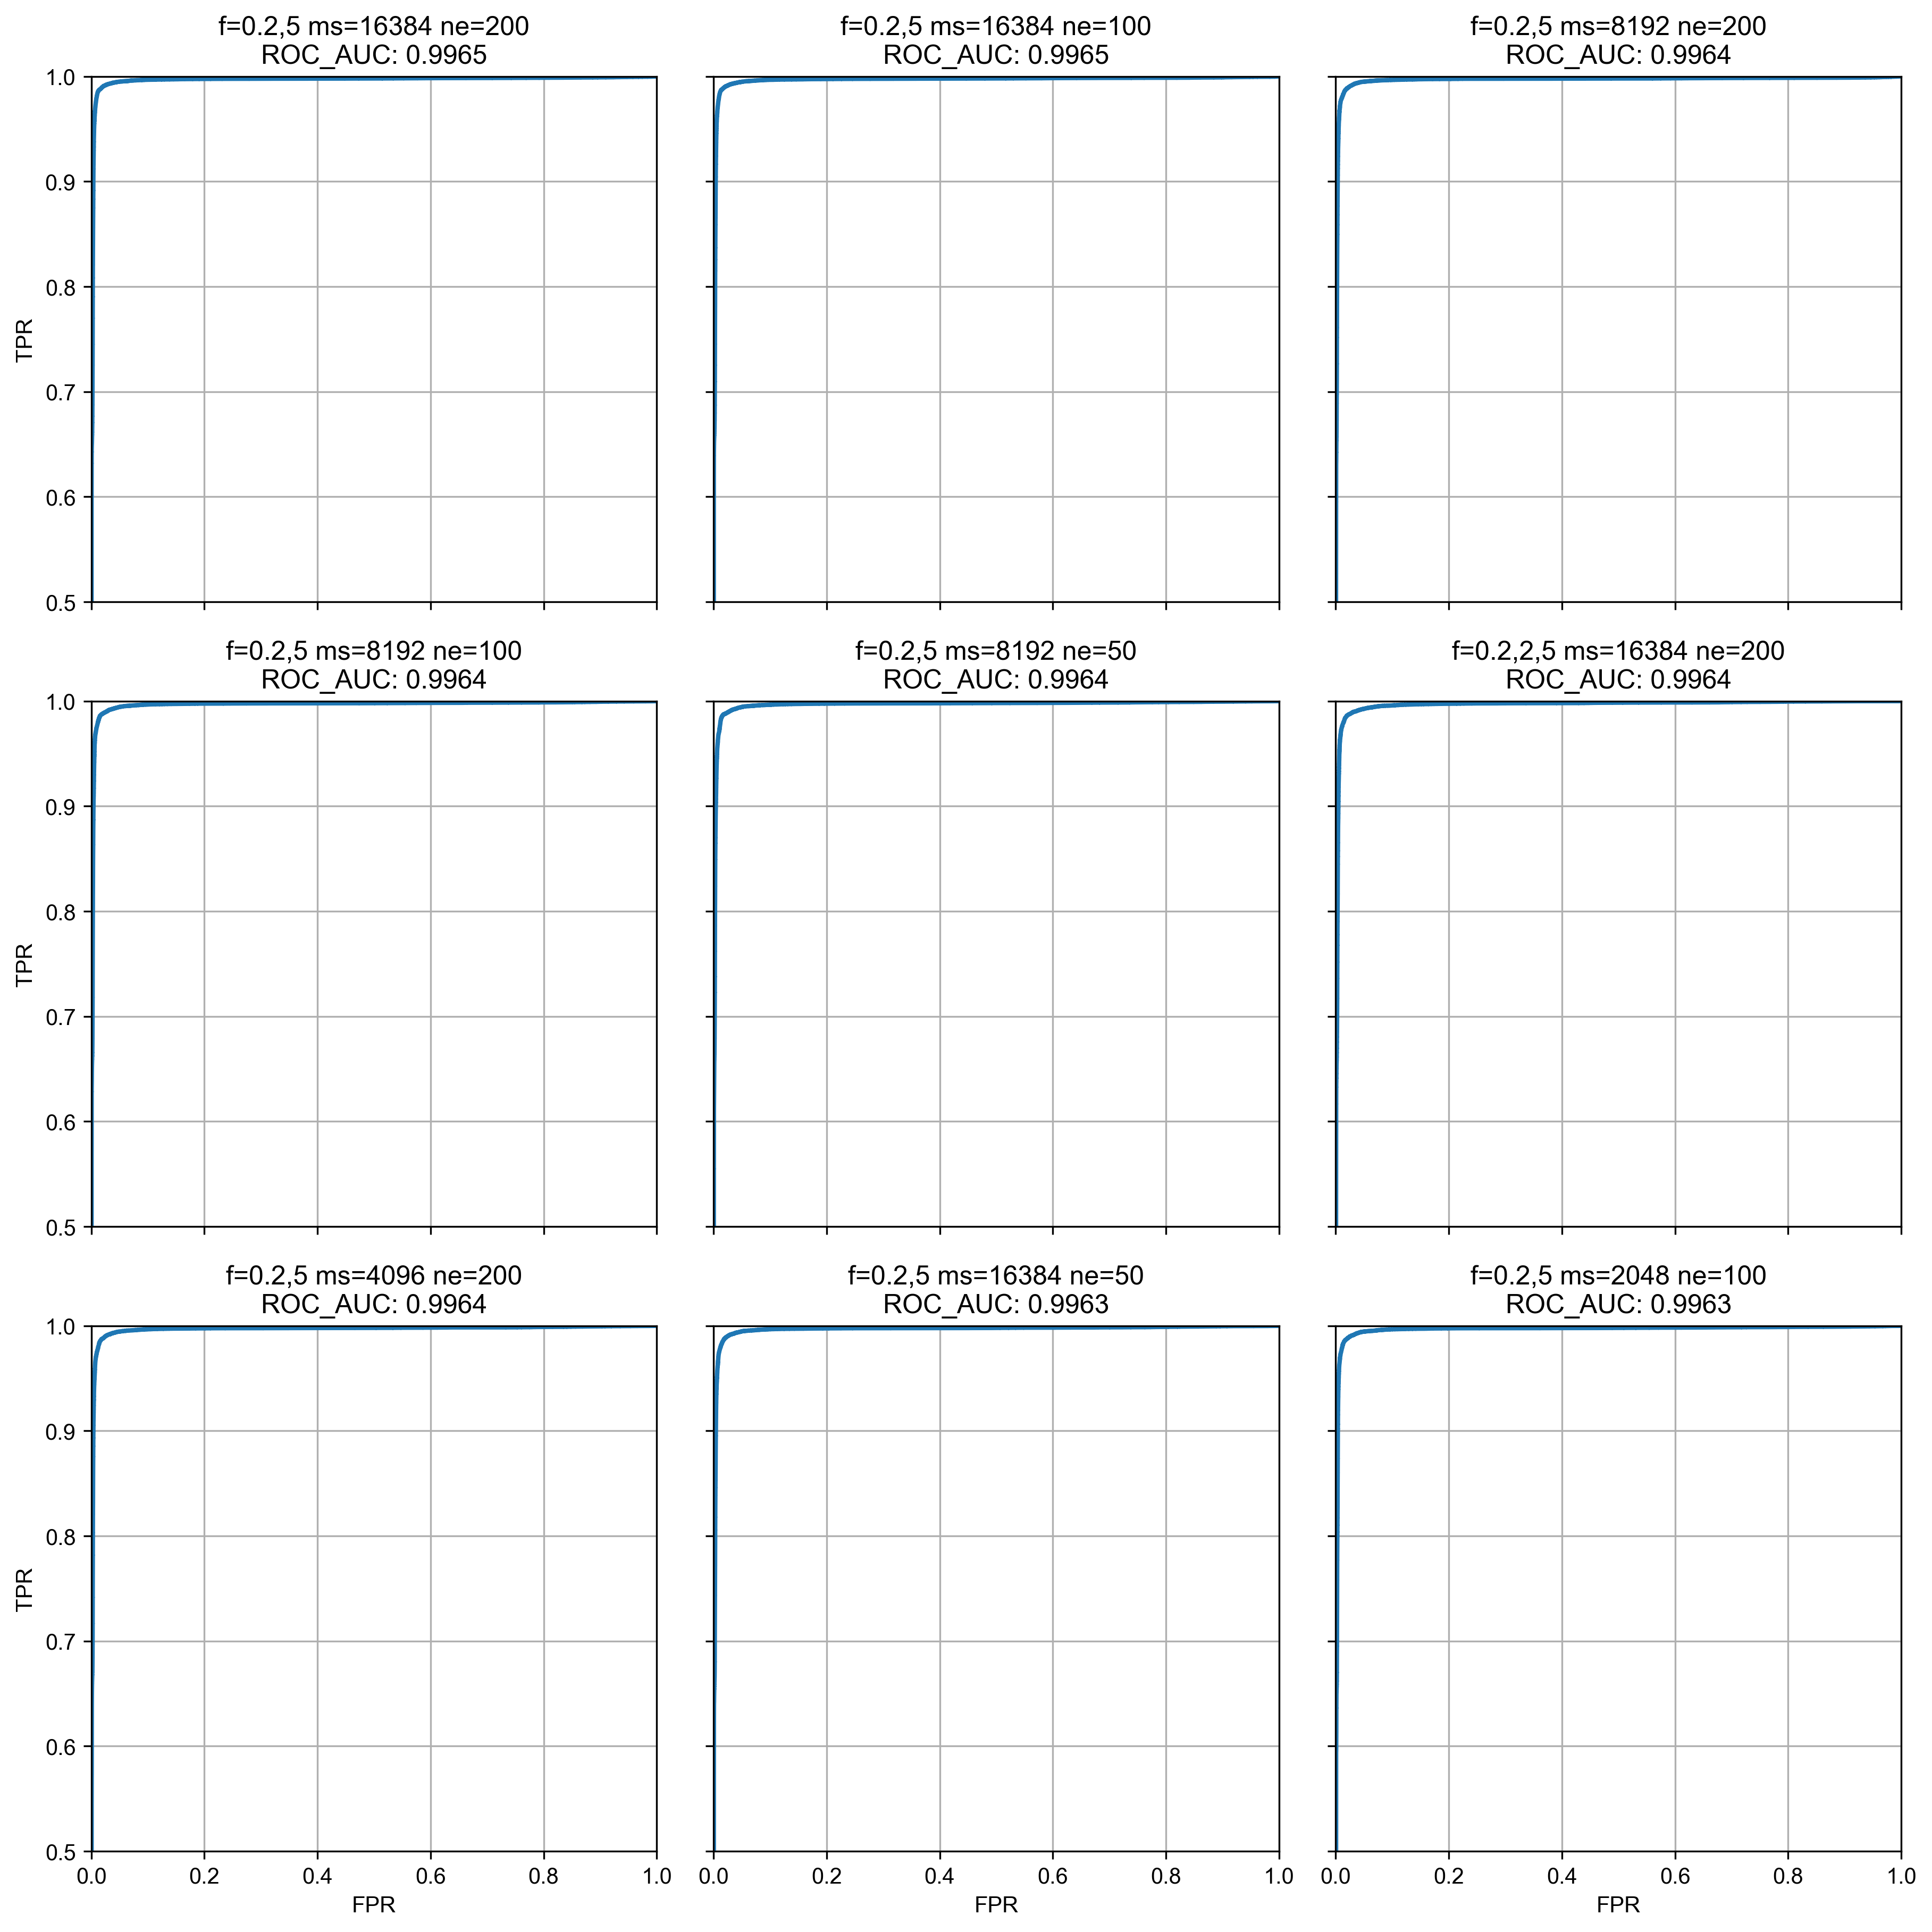

P/R curves

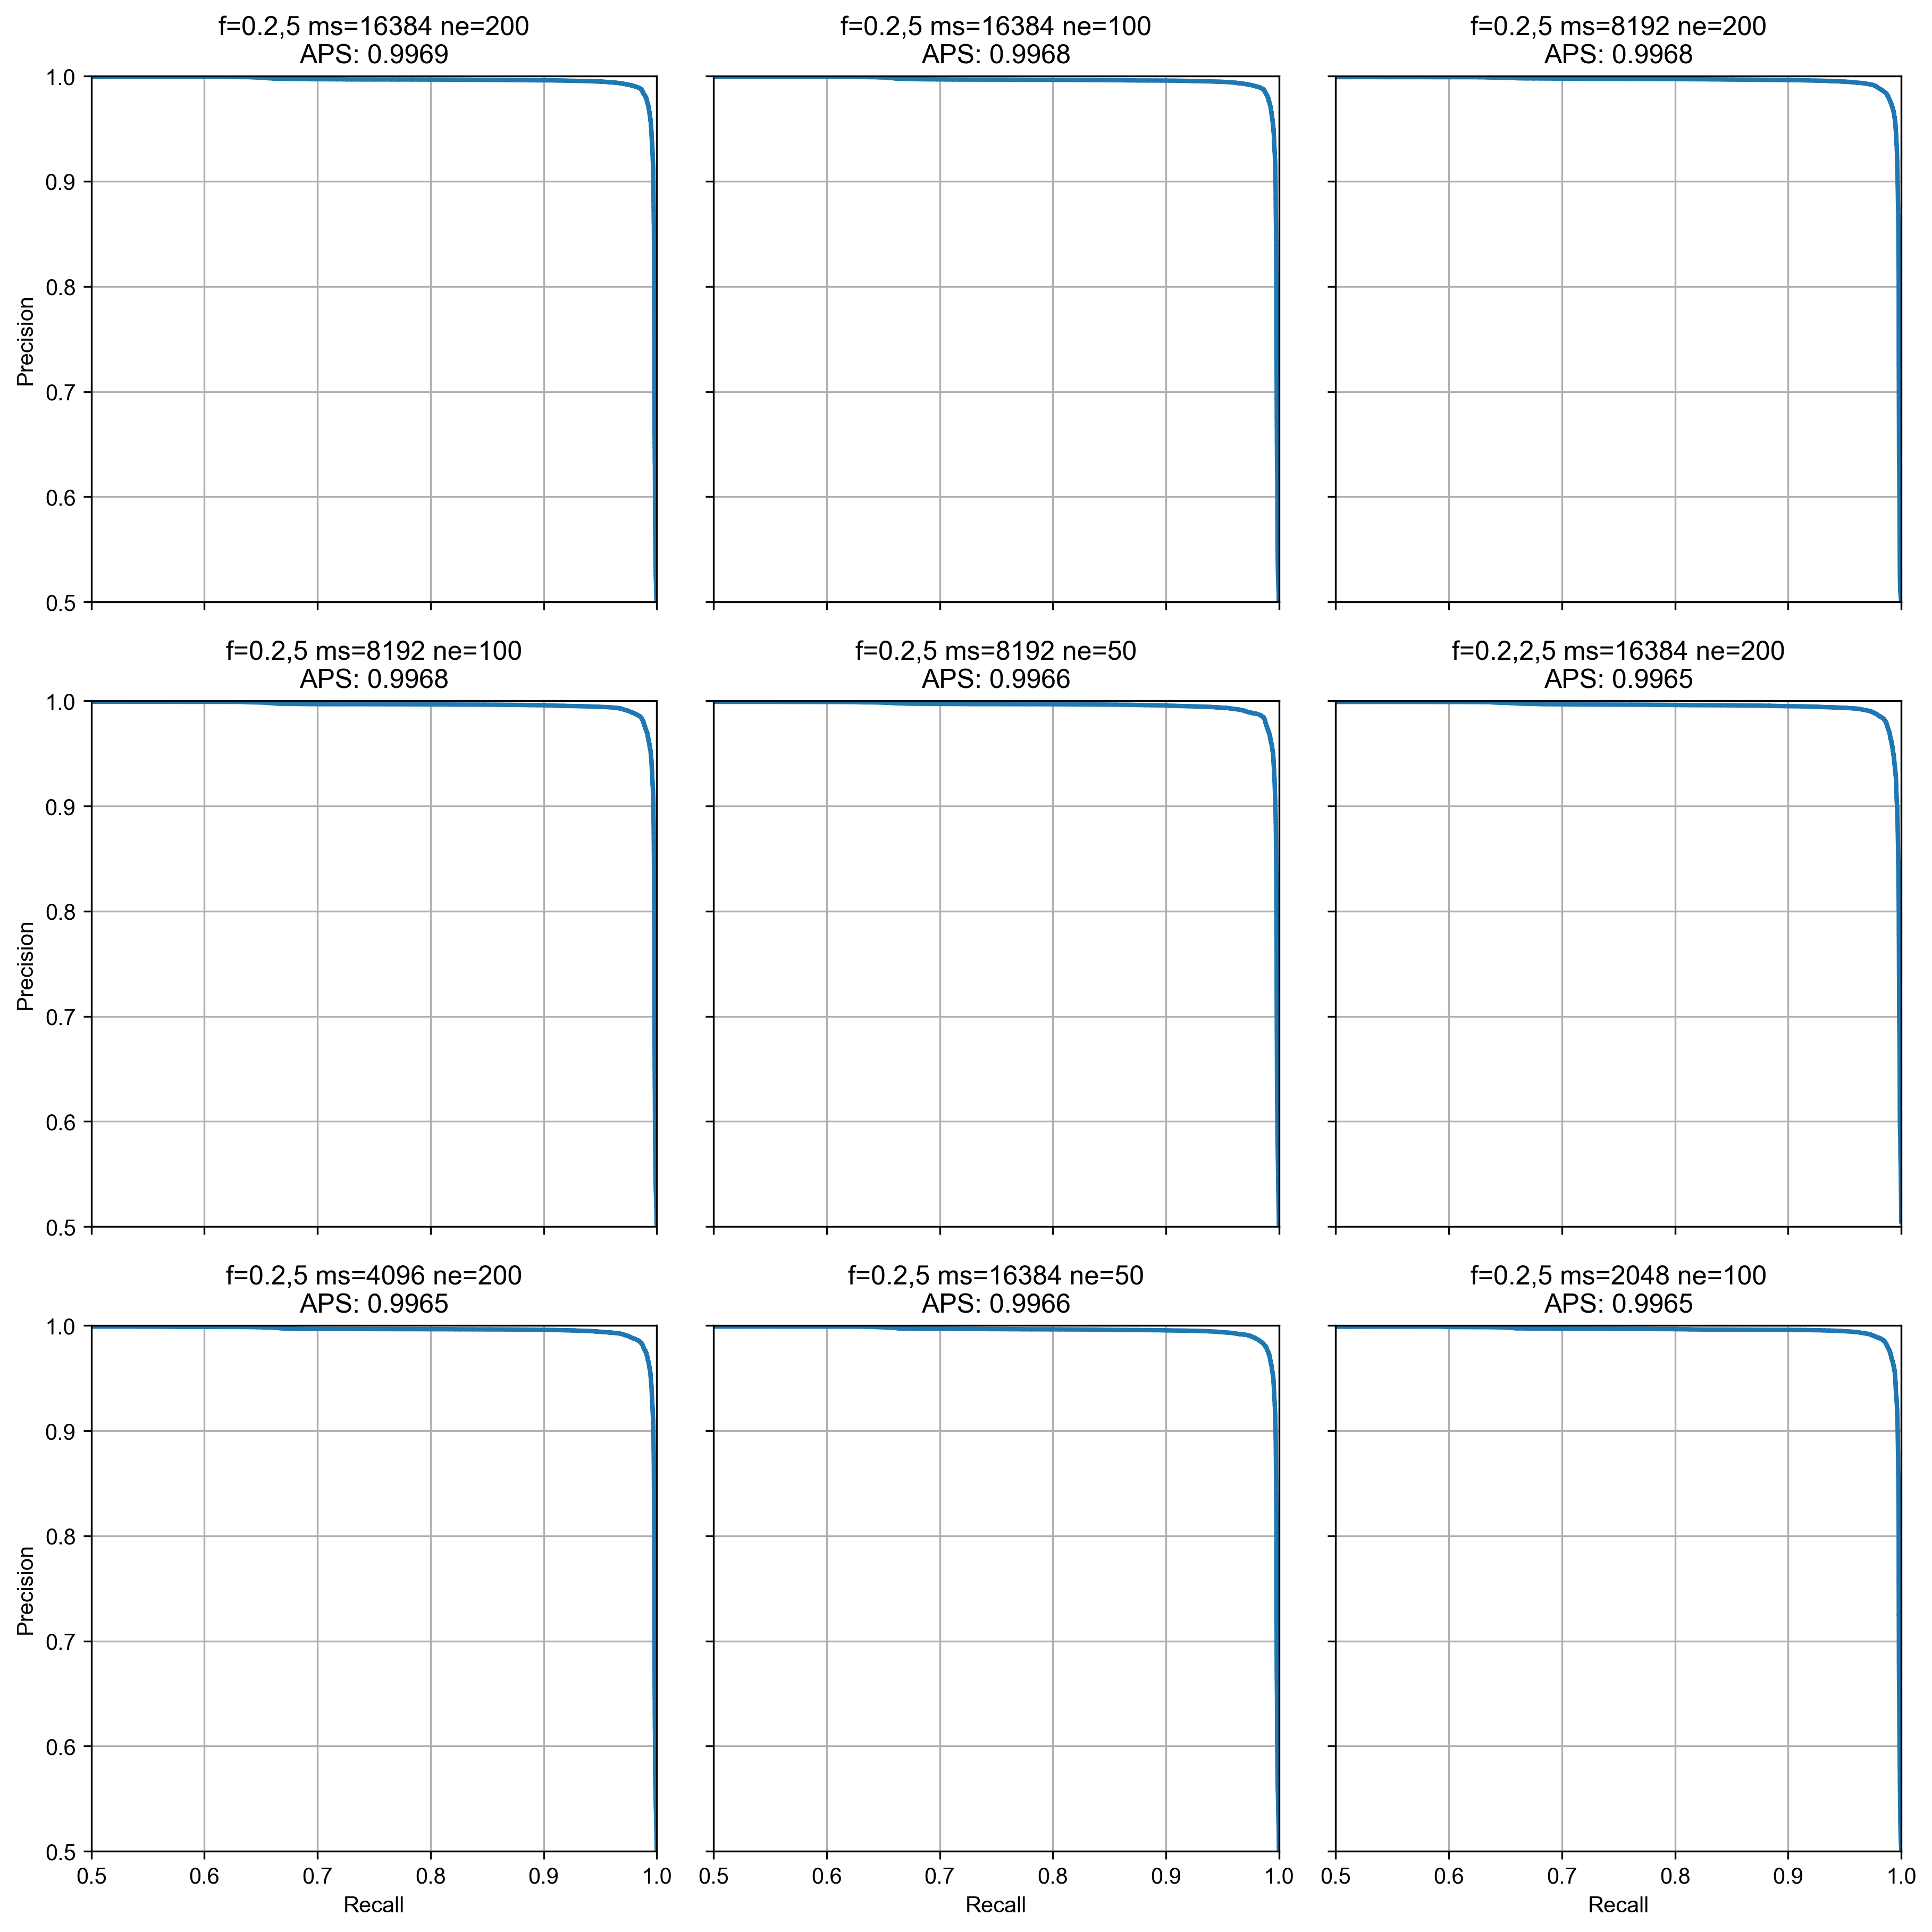

In [8]:
printhtml('<h3>Displaying some EM for the models just loaded</h3>')
print()
plotpred(pred_dfs, [0, 1], [0.5, 1], [0.5, 1], [0.5, 1])